In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
#!pip install pmdarima
import pmdarima as pm
from pmdarima.arima import auto_arima


In [2]:
#from pandas_datareader import data as pdr
import datetime as dt

import yfinance as yf

In [3]:
#legacy code from LSTM to retrieve prices
class price_volume_data:
    """A class for retrieving and analyzing price and volume data."""
    def __init__(self, tickers, start_date, end_date):
        """
        Initializes a new instance of the price_volume_data class.

        Args:
            tickers (list): A list of tickers for the assets to retrieve data for.
            start_date (str): The start date for the data retrieval (format: 'YYYY-MM-DD').
            end_date (str): The end date for the data retrieval (format: 'YYYY-MM-DD').
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.pv = self.__retrieve_data__()
        #self.lp, self.ret = self.__get_daily_returns__() #didn't need daily returns
        
    def __retrieve_data__(self):
        """
        Retrieves price and volume data for the given tickers from Yahoo Finance API.

        Returns:
            dict: A dictionary containing the price and volume data for each ticker.
        """

        data, failed = {}, []
        for ticker in self.tickers:
            try:
                df = yf.Ticker(ticker).history(start = self.start_date, end = self.end_date)
                
                data[ticker] = df
                
            except:
                failed.append(ticker)
                
        if failed:
            print('Tickers failed to extract: ', failed)
        
        return data
    
    def __get_daily_returns__(self):
        """
        Computes daily returns for the retrieved price data.

        Returns:
            pd.DataFrame: A DataFrame containing the daily price data.
            pd.DataFrame: A DataFrame containing the daily price returns.
        """
        df = pd.DataFrame()
        
        for ticker in self.pv:
            if df.empty:
                df = pd.DataFrame(self.pv[ticker]['Close'].copy())
            else:
                df = df.merge(self.pv[ticker]['Close'], how='outer',left_index=True, right_index=True)

        df.columns = self.tickers
        df = df.fillna(method = 'ffill')
        
        return df, df/df.shift(1) - 1
    
    def get_info(self, ticker = None):
        """
        Prints information about the price and volume data for the specified ticker.
        If no ticker is provided, prints information for all tickers.

        Args:
            ticker (str, optional): The ticker symbol for the asset. Defaults to None.
        """
        if ticker:
            self.pv[ticker].info()
        
        else:
            for ticker in self.pv:
                self.pv[ticker].info()
                
        return None
    
    def plot_price_trends(self, normalize = True, reference = -1):
        """
        Plots the close prices of selected assets over time.

        Args:
            normalize (bool, optional): Indicates whether to normalize the prices. Defaults to True.
            reference (int, optional): Reference point for normalization. Defaults to -1.
        """
        f, ax = plt.subplots(1,1,figsize=(12,5))
        # plot prices
        for key in self.pv:
            last_price = self.pv[key].loc[:, 'Close'].copy()
            if normalize:
                if reference == -1:
                    last_price /= last_price.iloc[0]
                elif reference == 0:
                    midpt = int(last_price.shape[0]/2)
                    last_price /= last_price.iloc[midpt]
                else:
                    last_price /= last_price.iloc[-1]
            last_price.plot(ax = ax, label = key)
        
        ax.title.set_text('Close Prices of selected assets')
        ax.set(ylabel = 'Normalized Price to start of observation')
        ax.legend()
        plt.show()
        
    def plot_corr(self, method='pearson', output = False, series = 'price'):
        """
        Plots the correlation matrix between asset prices or returns.

        Args:
            method (str, optional): The correlation method to use. Defaults to 'pearson'.
            output (bool, optional): Indicates whether to return the correlation matrix. Defaults to False.
            series (str, optional): Indicates whether to use 'price' or 'returns'. Defaults to 'price'.

        Returns:
            pd.DataFrame or None: The correlation matrix if output=True, None otherwise.
        """
        corr_matrix = self.lp.corr(method) if series == 'price' else self.ret.corr(method)
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        f, ax = plt.subplots(figsize=(5, 5))
        sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True)
        
        return corr_matrix if output else None
        
        
    def get_technical_indicators(self, indicators = None, normalize = True):
        """
        Computes and adds various technical indicators to the price data.

        Args:
            indicators (list, optional): A list of tuples specifying the indicators and their parameters.
                Defaults to None.
            normalize (bool, optional): Indicates whether to normalize the indicator values. Defaults to True.
        """
        if not indicators:
            indicators = [('SMA', 5), ('SMA', 14), ('ATR', 5), ('ATR', 14), ('ADX', 5),
                         ('ADX', 14), ('RSI', 5), ('RSI', 14), ('MACD', None), ('BBANDS', None)]
        
        for data in self.pv:
            df = self.pv[data]
            for indicator, param in indicators:
                
                if indicator == 'SMA':
                    df[f'{indicator}_{param}'] = talib.SMA(df['Close'], param)

                elif indicator == 'ATR':
                    df[f'{indicator}_{param}'] = talib.ATR(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'ADX':
                    df[f'{indicator}_{param}'] = talib.ADX(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'RSI':
                    df[f'{indicator}_{param}'] = talib.RSI(df['Close'], param) 
                    
                elif indicator == 'MACD':
                    df[f'{indicator}'], df[f'{indicator}_signal'], _ = talib.MACD(df['Close']) 
                    
                    
                elif indicator == 'BBANDS':
                    df[f'{indicator}_upp'], df[f'{indicator}_mid'], df[f'{indicator}_low'] = talib.BBANDS(df['Close'])
                    
                    
                else:
                    print('Indicators not built into the class. Please run TALIB manually!')
            
            df = df.replace([np.inf, -np.inf], np.nan, inplace = True)
            
        return None              

In [4]:
sheet_name = ['20220524','20220823','20221122','20230221','20230523']
symbols = pd.read_excel("target_stock_universe.xlsx", sheet_name = sheet_name[0]) # change here to get the other sheet
symbols['Ticker_Symbol'] = symbols['Ticker'].str.split().str[0]+".L"
symbols = symbols[symbols['Ticker_Symbol']!='HSV.L']
symbols = symbols[symbols['Ticker_Symbol']!='HBR.L']


symbols_short = symbols['Ticker_Symbol']
symbols_short

0      ICP.L
1     ABDN.L
2     SMDS.L
4       HL.L
5      DPH.L
6      HIK.L
7     HWDN.L
8      IDS.L
9      ITV.L
10     CCL.L
11    INVP.L
12     CNA.L
13    CTEC.L
14     UTG.L
15    JMAT.L
16    WEIR.L
18    BBOX.L
19     EZJ.L
20     IMI.L
21     DLN.L
22     TUI.L
23     SXS.L
24     HSX.L
25     DLG.L
26     EMG.L
27    DPLM.L
28     IGG.L
29    WIZZ.L
30    FRAS.L
31    TATE.L
32     BEZ.L
33     PNN.L
34     RSW.L
Name: Ticker_Symbol, dtype: object

In [5]:
data = price_volume_data(symbols_short.to_list(),'2017-05-25', '2022-05-31')
data.pv

{'ICP.L':                                   Open         High          Low        Close  \
 Date                                                                            
 2017-05-25 00:00:00+01:00   632.439194   728.545150   629.928046   713.044189   
 2017-05-26 00:00:00+01:00   712.269068   725.057359   688.630106   691.342773   
 2017-05-30 00:00:00+01:00   687.080036   694.442992   681.267177   682.429749   
 2017-05-31 00:00:00+01:00   681.654714   687.855098   680.492142   683.979858   
 2017-06-01 00:00:00+01:00   685.917457   694.055461   679.717073   686.692505   
 ...                                ...          ...          ...          ...   
 2022-05-24 00:00:00+01:00  1312.555141  1337.080392  1308.921770  1323.909424   
 2022-05-25 00:00:00+01:00  1344.347116  1344.347116  1307.105067  1324.817749   
 2022-05-26 00:00:00+01:00  1379.318205  1451.531440  1372.051465  1425.643677   
 2022-05-27 00:00:00+01:00  1419.285366  1457.889927  1417.014509  1449.714844   
 2022-0

In [6]:
#data wrangling
#objective is to have a dataframe of close prices. columns = stocks and rows = price observations (time series)

df = data.pv[symbols_short[0]]["Close"]
for stock in symbols_short[1:]:
    
    df = pd.concat([df, data.pv[stock]["Close"]], axis = 1)

df.columns = symbols_short
df.index = pd.to_datetime(df.index.date)

In [7]:
df

Ticker_Symbol        ICP.L      ABDN.L      SMDS.L         HL.L        DPH.L  \
2017-05-25      713.044189  277.341248  304.290009  1240.069458  1759.865112   
2017-05-26      691.342773  273.916382  308.726990  1226.830322  1742.154785   
2017-05-30      682.429749  274.630005  311.732666  1233.008545  1760.797363   
2017-05-31      683.979858  273.131592  312.877747  1233.891235  1812.064575   
2017-06-01      686.692505  274.772614  315.811859  1240.952026  1771.982910   
...                    ...         ...         ...          ...          ...   
2022-05-24     1323.909424  167.978851  271.082397   791.668152  3416.174561   
2022-05-25     1324.817749  167.802094  271.897583   788.804626  3431.908203   
2022-05-26     1425.643677  173.149460  275.792175   815.912659  3492.876221   
2022-05-27     1449.714844  173.370438  279.958496   813.240051  3549.910645   
2022-05-30     1464.248291  175.403320  282.856812   824.121399  3567.611328   

Ticker_Symbol        HIK.L      HWDN.L       IDS.L       ITV.L        CCL.L  \
2017-05-25     1461.546143  389.914948  312.986084  145.077591  4358.520020   
2017-05-26     1485.246826  388.548889  313.557617  145.952438  4411.258789   
2017-05-30     1470.324219  389.829529  313.057495  145.004684  4432.710938   
2017-05-31     1481.735718  386.756042  315.343597  142.671799  4442.544434   
2017-06-01     1498.414185  391.366333  315.272156  139.682770  4500.645508   
...                    ...         ...         ...         ...          ...   
2022-05-24     1624.289185  623.591675  299.203094   66.243507   872.000000   
2022-05-25     1611.314087  635.875488  299.203094   67.479607   884.400024   
2022-05-26     1637.744873  646.047974  312.174591   68.809349   965.599976   
2022-05-27     1622.847534  648.543030  306.165741   66.149864   986.400024   
2022-05-30     1640.628296  655.644592  313.700653   65.962585  1011.500000   

Ticker_Symbol  ...       DLG.L       EMG.L       DPLM.L       IGG.L  WIZZ.L  \
2017-05-25     ...  237.465958  111.699074  1002.071411  352.374573  2204.0   
2017-05-26     ...  235.016464  111.770233  1012.875610  350.496918  2285.0   
2017-05-30     ...  237.057724  112.054787  1008.373779  346.428650  2343.0   
2017-05-31     ...  237.193787  111.912514  1007.473694  365.518219  2279.0   
2017-06-01     ...  236.309265  112.552803  1010.174561  366.144165  2280.0   
...            ...         ...         ...          ...         ...     ...   
2022-05-24     ...  241.485413  225.025497  2417.814697  639.604492  2976.0   
2022-05-25     ...  244.091370  230.489075  2456.812012  644.102478  3069.0   
2022-05-26     ...  247.179932  238.267746  2491.138672  649.499939  3034.0   
2022-05-27     ...  250.944077  238.730759  2524.484619  652.198730  2993.0   
2022-05-30     ...  250.364975  240.397614  2553.907471  652.198730  3094.0   

Ticker_Symbol      FRAS.L      TATE.L       BEZ.L       PNN.L        RSW.L  
2017-05-25     297.299988  598.315613  414.456573  812.135315  3365.308350  
2017-05-26     300.000000  584.735718  413.562988  804.392639  3382.894531  
2017-05-30     299.000000  588.729675  420.354401  801.381653  3419.916016  
2017-05-31     297.700012  589.528687  421.962952  792.348389  3426.394775  
2017-06-01     295.000000  589.129211  421.337402  788.476807  3477.300293  
...                   ...         ...         ...         ...          ...  
2022-05-24     634.000000  729.711487  467.812714  984.604126  3860.357666  
2022-05-25     639.000000  740.266174  462.334351  955.039062  3732.920898  
2022-05-26     672.000000  733.069824  468.204010  924.578186  3821.146240  
2022-05-27     689.500000  724.434143  476.617218  905.764099  3844.673096  
2022-05-30     695.000000  722.515137  473.095398  921.890442  4005.439697  

[1268 rows x 33 columns]

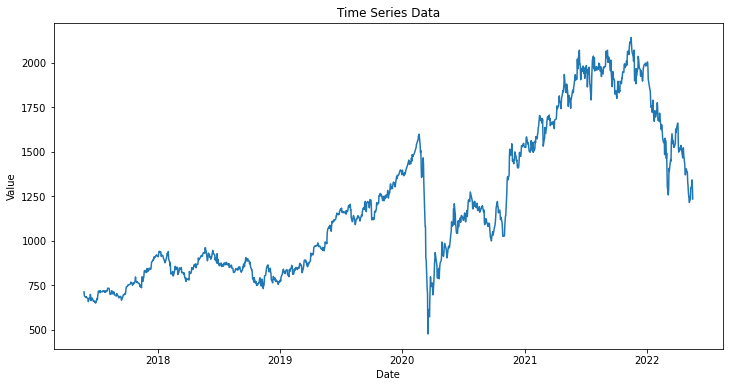

ADF Statistic: -1.7268616749702272
p-value: 0.4173283671646689
Critical Values:
1%: -3.435571295403709
5%: -2.863845736356174
10%: -2.567997600196822
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12101.434, Time=3.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12103.434, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12103.434, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12099.684, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12103.326, Time=0.44 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.780 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1261
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6048.842
Date:                Thu, 12 Oct 2023   AIC                          12099.684
Time:                        13:56:29   BIC       

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


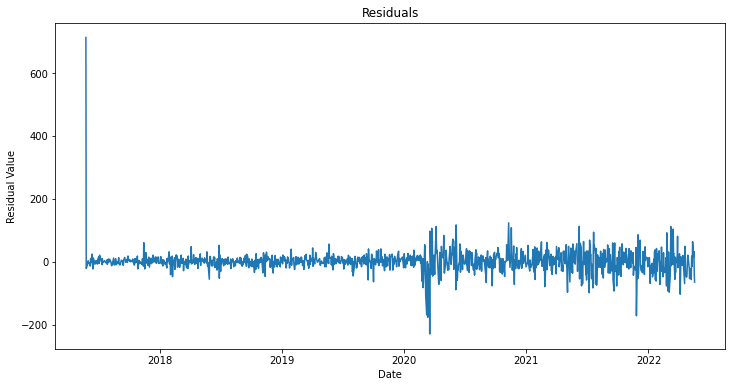

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


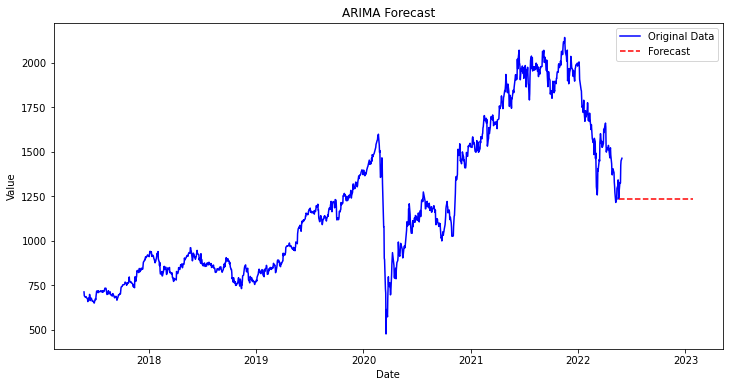

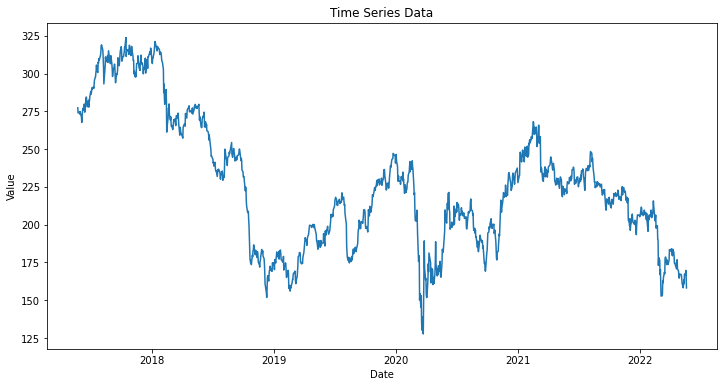

ADF Statistic: -1.702073809665625
p-value: 0.4300443057393688
Critical Values:
1%: -3.4355796466416777
5%: -2.863849421064024
10%: -2.5679995625056926
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7299.096, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7300.241, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7300.258, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7297.685, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7302.815, Time=0.42 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.751 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1261
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3647.843
Date:                Thu, 12 Oct 2023   AIC                           7297.685
Time:                        13:56:30   BIC           

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


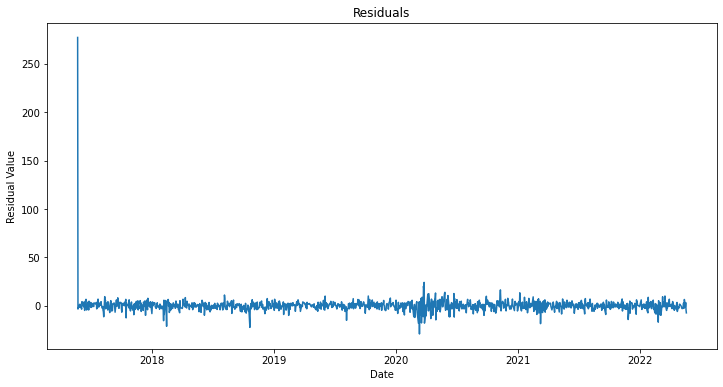

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


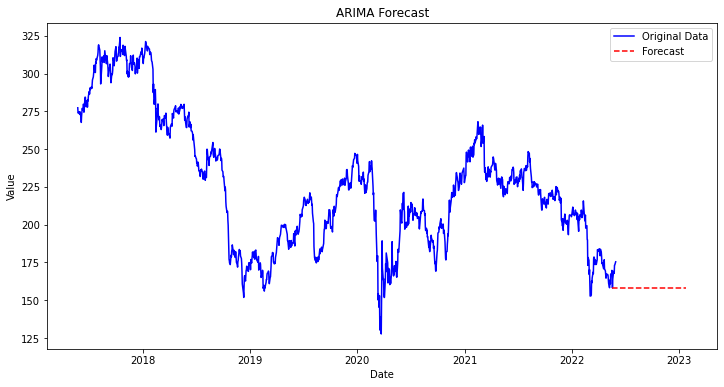

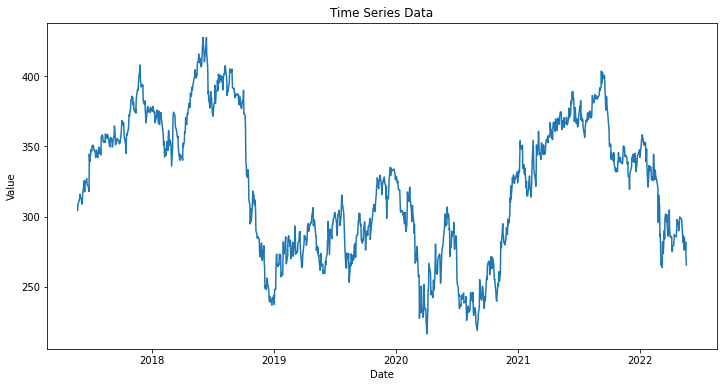

ADF Statistic: -2.08970154607247
p-value: 0.24867577473037483
Critical Values:
1%: -3.435550533536195
5%: -2.863836575823745
10%: -2.567992721718317
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8125.891, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8126.504, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8126.456, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8123.924, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8126.941, Time=0.32 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.689 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1261
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4060.962
Date:                Thu, 12 Oct 2023   AIC                           8123.924
Time:                        13:56:32   BIC             

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


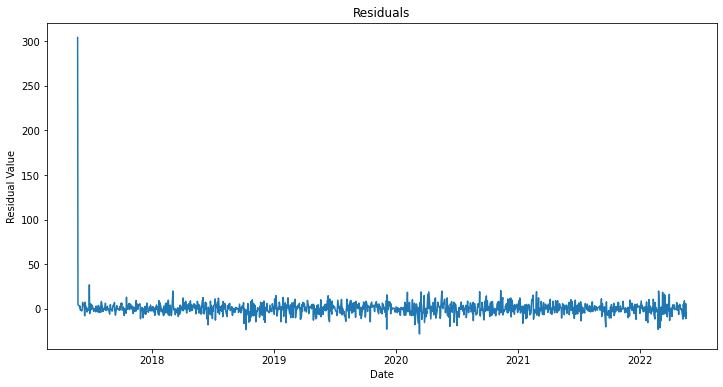

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


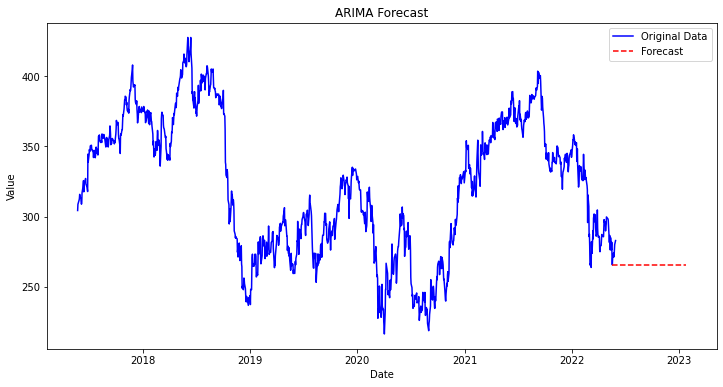

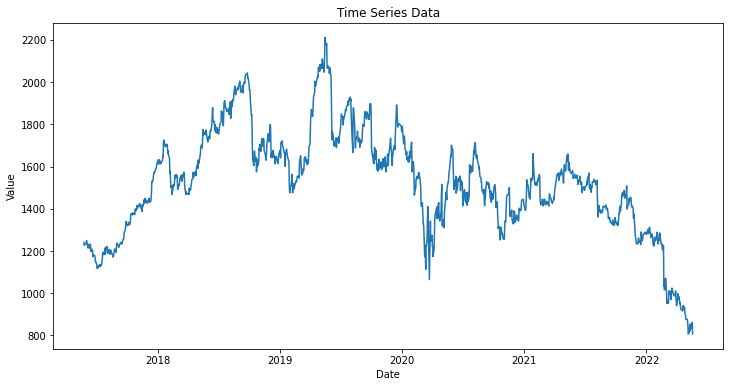

ADF Statistic: -1.7314304607466957
p-value: 0.4149956199139831
Critical Values:
1%: -3.4355880246374304
5%: -2.8638531175675896
10%: -2.568001531098063
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12331.761, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12333.433, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12333.419, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12329.905, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12335.383, Time=0.51 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.883 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1261
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6163.952
Date:                Thu, 12 Oct 2023   AIC                          12329.905
Time:                        13:56:34   BIC     

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


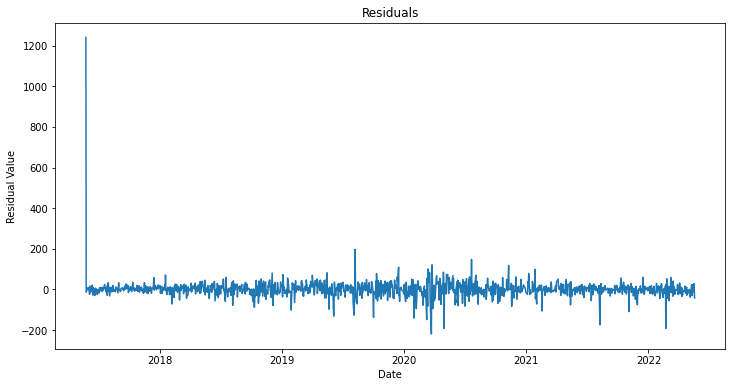

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


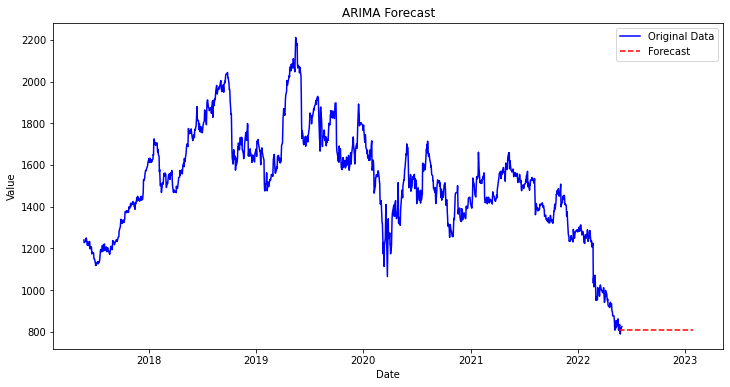

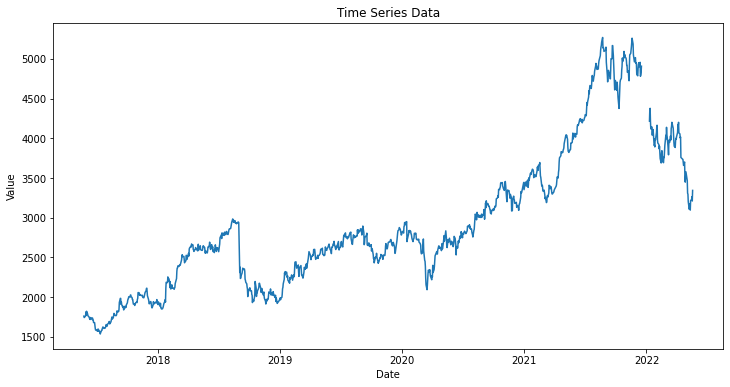

ADF Statistic: -1.5043814965288063
p-value: 0.5313427724375028
Critical Values:
1%: -3.435592223709696
5%: -2.8638549702604803
10%: -2.56800251776
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13642.133, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13641.262, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13641.300, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13640.763, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13643.245, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.372 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1252
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6819.382
Date:                Thu, 12 Oct 2023   AIC                          13640.763
Time:                        13:56:35   BIC          

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


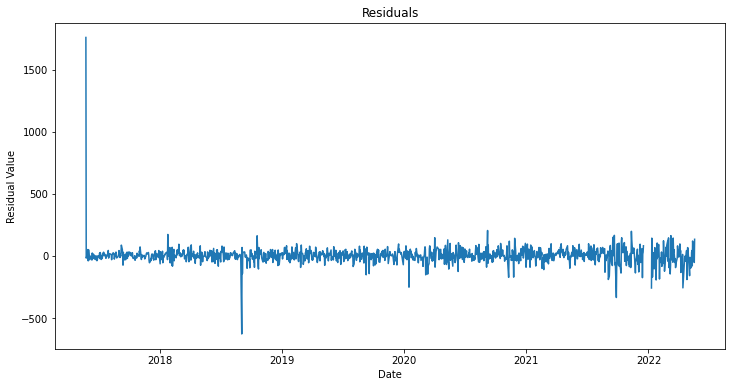

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


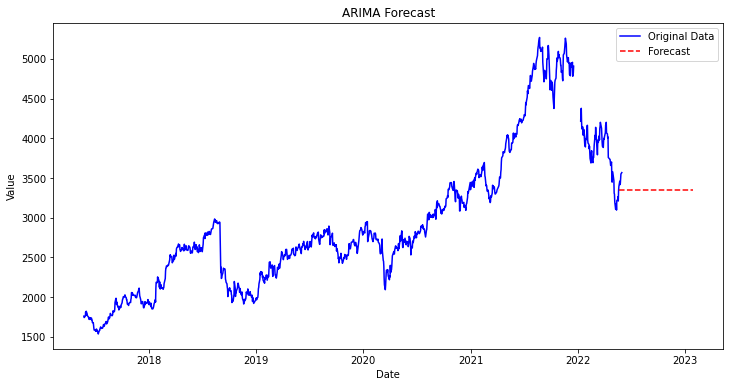

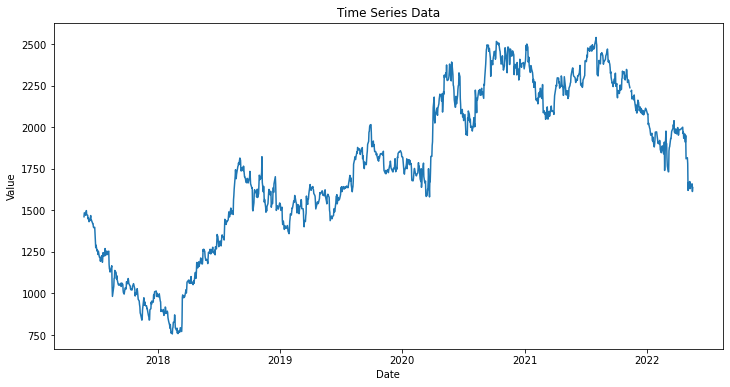

ADF Statistic: -1.337361756228509
p-value: 0.6119107349357588
Critical Values:
1%: -3.4355588184378574
5%: -2.8638402312881497
10%: -2.5679946684494275
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12573.653, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12573.604, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12573.500, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12571.672, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12574.291, Time=0.49 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.828 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1260
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6284.836
Date:                Thu, 12 Oct 2023   AIC                          12571.672
Time:                        13:56:37   BIC     

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


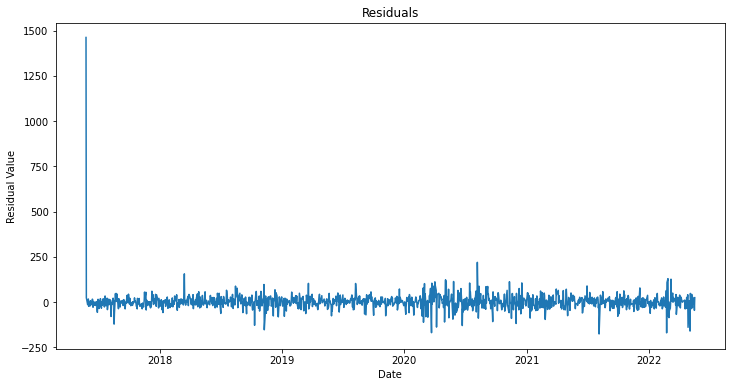

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


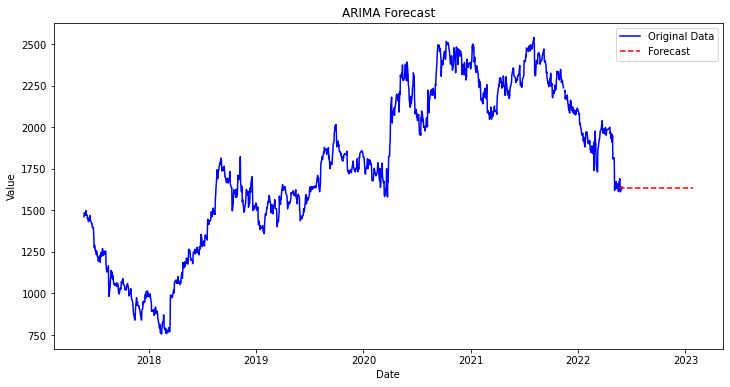

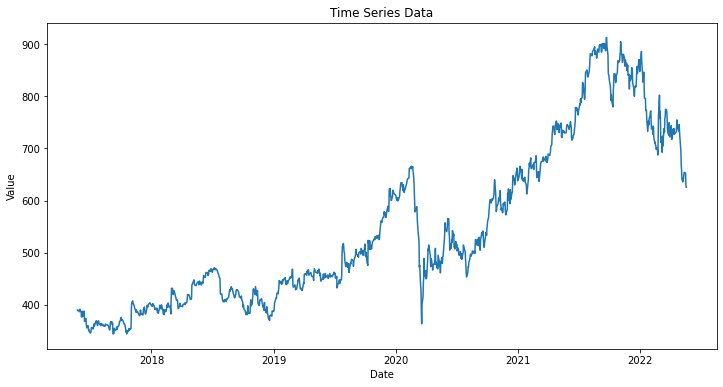

ADF Statistic: -1.298566471535499
p-value: 0.6298278992299877
Critical Values:
1%: -3.435621806786881
5%: -2.8638680226791444
10%: -2.5680094689100477
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9387.282, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9386.425, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9386.636, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9385.722, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9387.676, Time=0.35 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.901 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1261
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4691.861
Date:                Thu, 12 Oct 2023   AIC                           9385.722
Time:                        13:56:39   BIC           

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


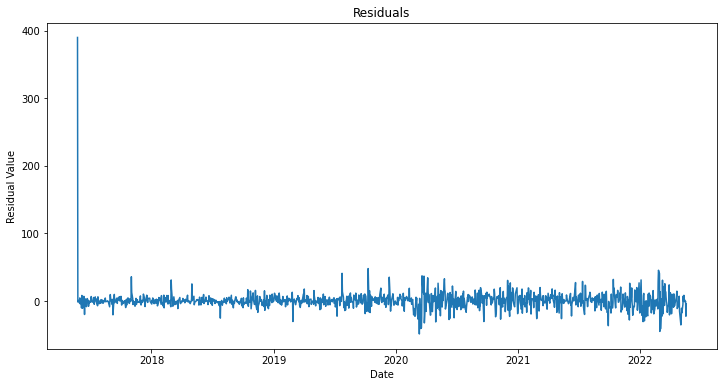

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


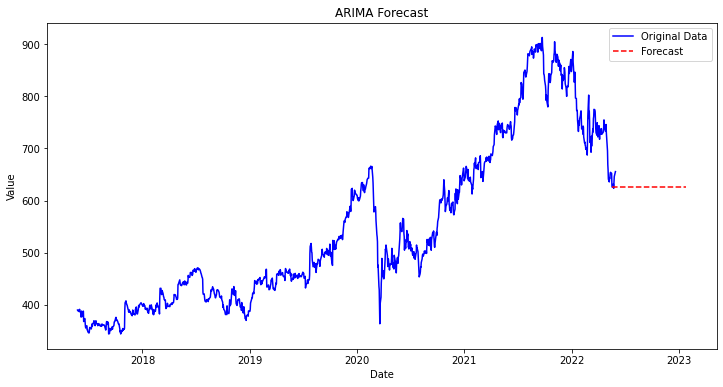

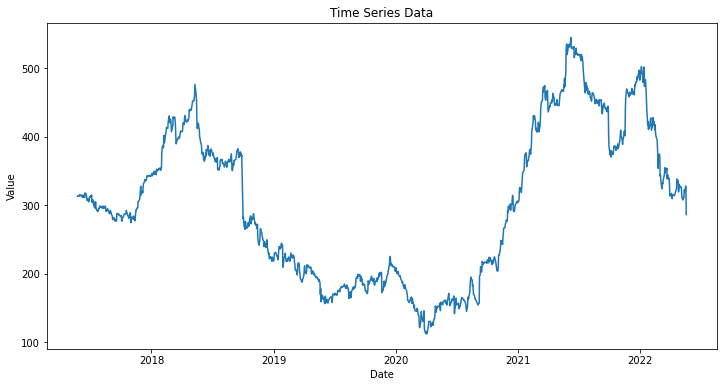

ADF Statistic: -1.1865356567896312
p-value: 0.6793607492582509
Critical Values:
1%: -3.4355588184378574
5%: -2.8638402312881497
10%: -2.5679946684494275
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8389.296, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8389.083, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8389.308, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8387.309, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8386.466, Time=0.92 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8387.980, Time=0.62 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8388.280, Time=0.65 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8387.433, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8387.343, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8388.825, Time=0.71 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8384.495, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=8387.32

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


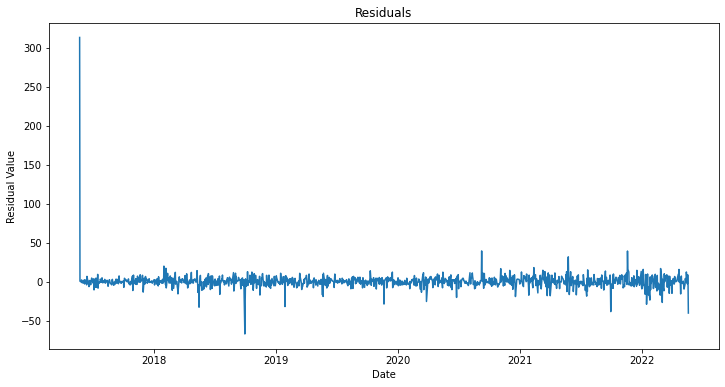

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


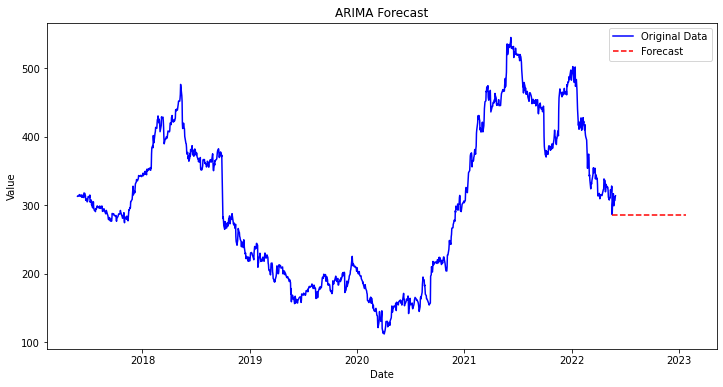

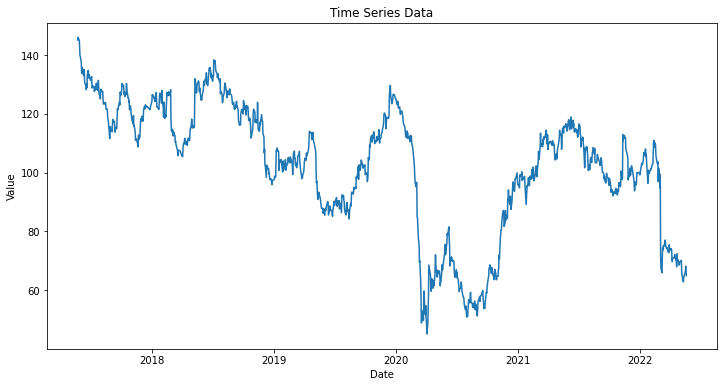

ADF Statistic: -1.9903873252099422
p-value: 0.2908037624406158
Critical Values:
1%: -3.435550533536195
5%: -2.863836575823745
10%: -2.567992721718317
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5628.752, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5630.752, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5630.752, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5627.755, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5632.732, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.515 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1261
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2812.877
Date:                Thu, 12 Oct 2023   AIC                           5627.755
Time:                        13:56:46   BIC            

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


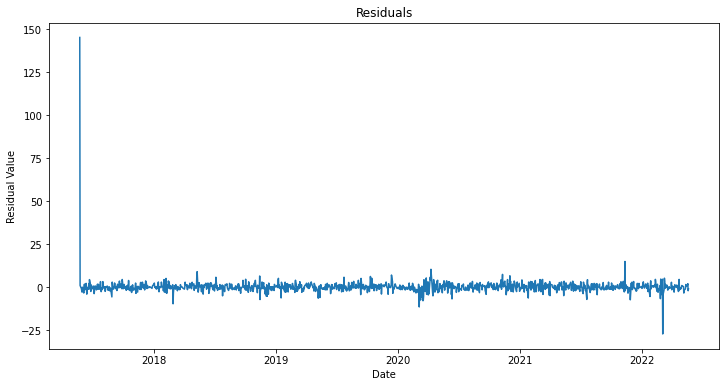

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


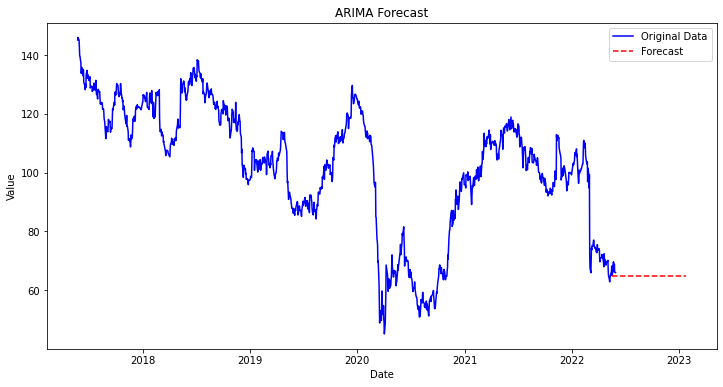

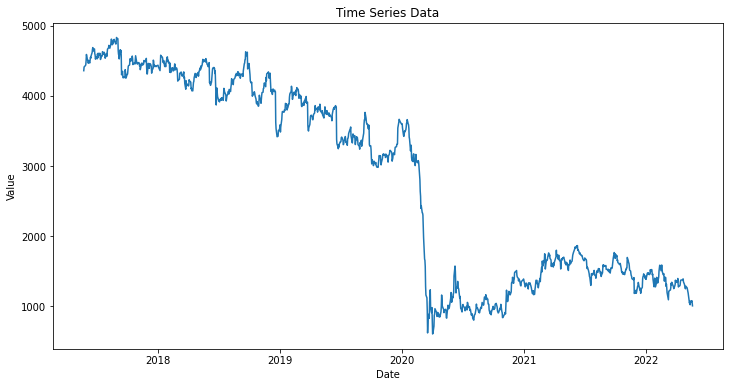

ADF Statistic: -1.059193228709976
p-value: 0.7310679491041912
Critical Values:
1%: -3.4356090875394525
5%: -2.863862410805964
10%: -2.568006480268158
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14040.944, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14039.195, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14039.447, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14041.153, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=14039.604, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14039.341, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14041.290, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=14039.173, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=14039.443, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=14039.060, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=14039.450, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


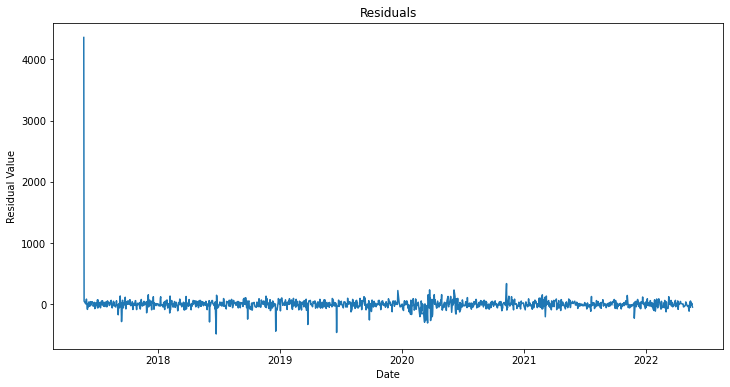

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


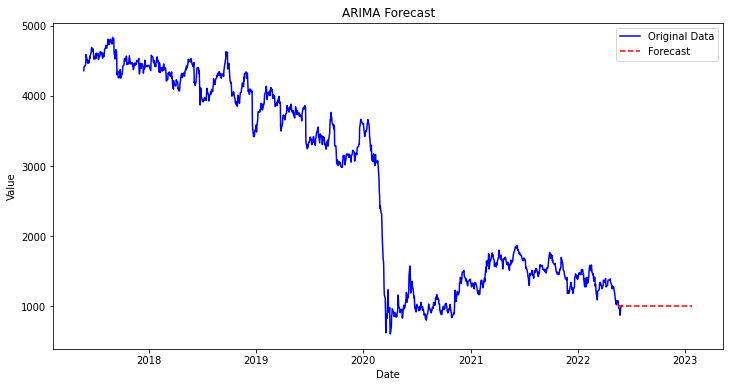

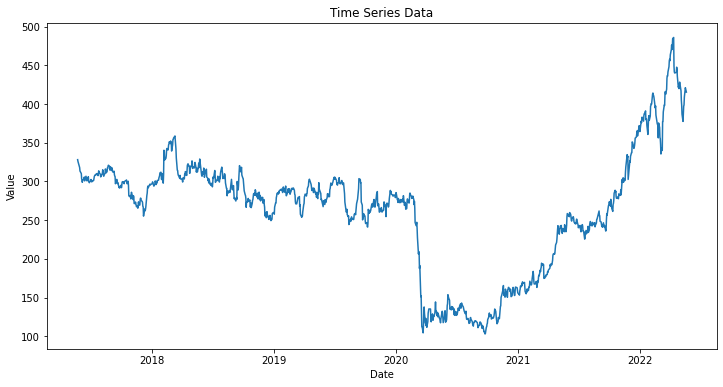

ADF Statistic: -0.95819675565888
p-value: 0.7682042366236637
Critical Values:
1%: -3.4355629707955395
5%: -2.863842063387667
10%: -2.567995644141416
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7973.014, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7974.837, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7974.861, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7971.198, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7969.995, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7968.173, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7969.165, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7969.393, Time=0.91 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7970.095, Time=0.75 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7968.347, Time=0.89 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=7968.476, Time=0.31 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7969.829, T

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


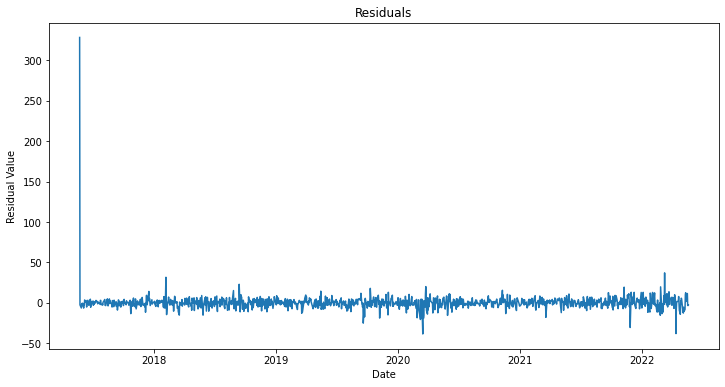

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


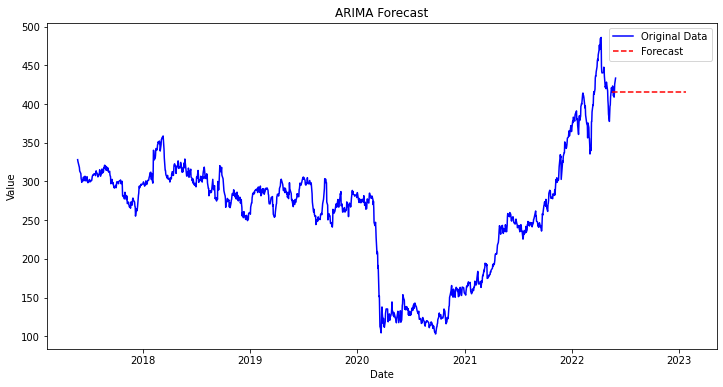

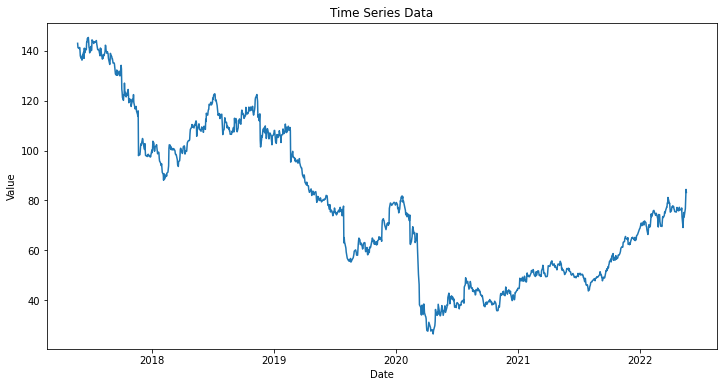

ADF Statistic: -2.0953738026856703
p-value: 0.24637888315856937
Critical Values:
1%: -3.435550533536195
5%: -2.863836575823745
10%: -2.567992721718317
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4869.910, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4871.902, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4871.901, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4868.928, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4873.673, Time=0.37 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.710 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1261
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2433.464
Date:                Thu, 12 Oct 2023   AIC                           4868.928
Time:                        13:57:00   BIC           

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


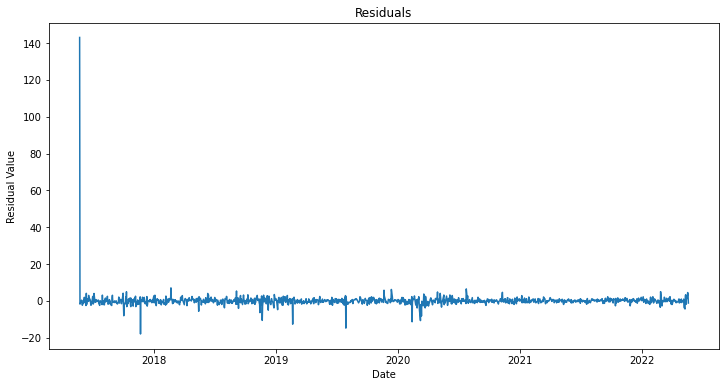

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


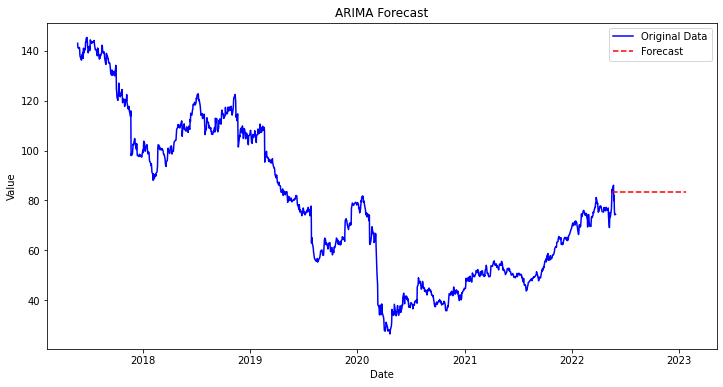

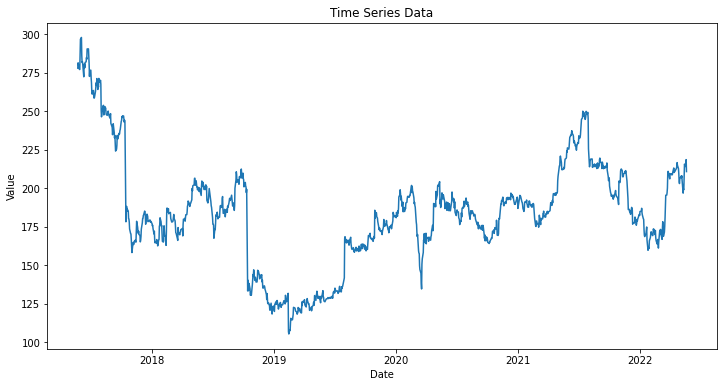

ADF Statistic: -2.9074752734065674
p-value: 0.04448560485349894
Critical Values:
1%: -3.435550533536195
5%: -2.863836575823745
10%: -2.567992721718317
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7224.323, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7225.232, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7225.273, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7222.521, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7227.114, Time=0.39 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.695 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1261
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3610.261
Date:                Thu, 12 Oct 2023   AIC                           7222.521
Time:                        13:57:02   BIC           

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


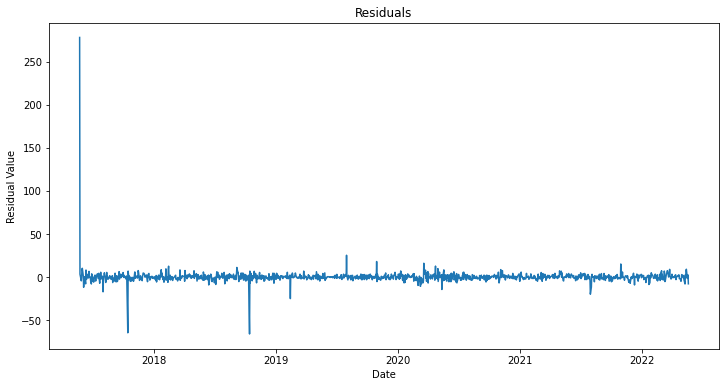

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


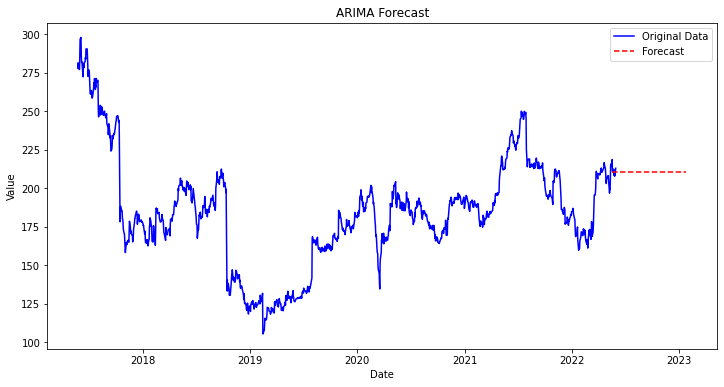

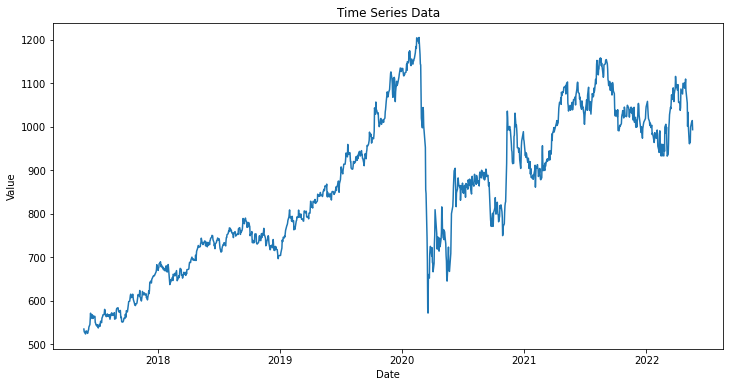

ADF Statistic: -2.2078790421529435
p-value: 0.20339825749785995
Critical Values:
1%: -3.4356048614183443
5%: -2.8638605461891617
10%: -2.5680054872544145
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10472.345, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10457.665, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10458.853, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10471.048, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10458.672, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10459.104, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10459.973, Time=0.73 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=10456.214, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=10457.189, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=10457.631, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=10457.426, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             :

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


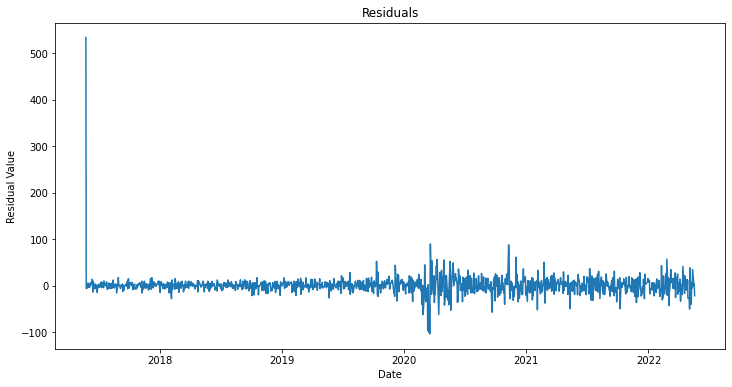

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


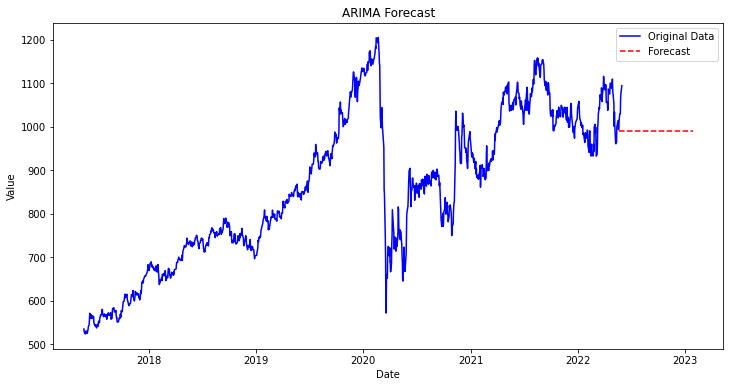

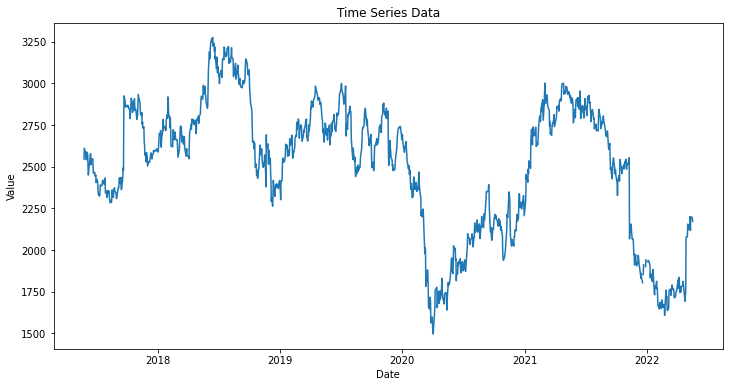

ADF Statistic: -2.1055525493007714
p-value: 0.24228776327113266
Critical Values:
1%: -3.4355671297788666
5%: -2.8638438984080117
10%: -2.5679966213893057
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13342.870, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13344.619, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13344.607, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13340.916, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13345.822, Time=0.56 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.811 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1257
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6669.458
Date:                Thu, 12 Oct 2023   AIC                          13340.916
Time:                        13:57:07   BIC   

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


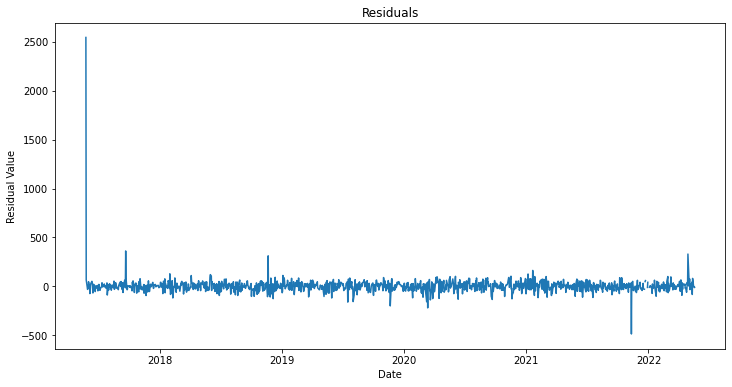

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


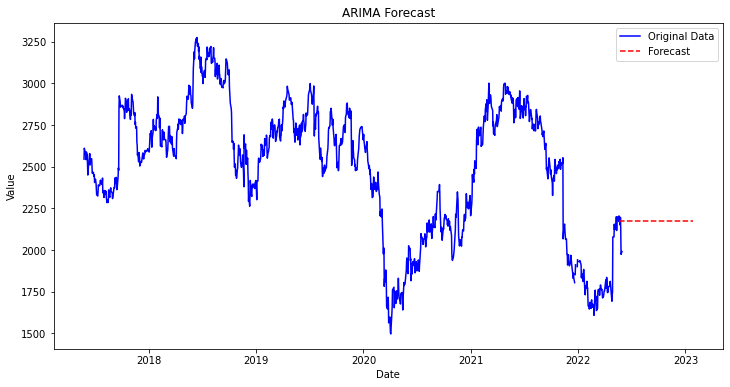

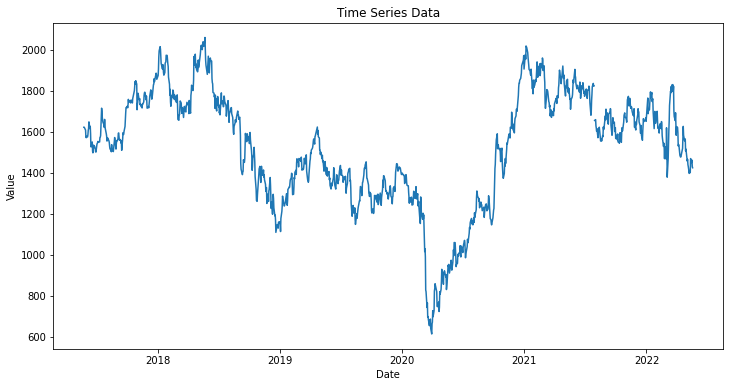

ADF Statistic: -2.1740773139659697
p-value: 0.2157880404327474
Critical Values:
1%: -3.435554672689999
5%: -2.863838402102491
10%: -2.5679936943096284
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12465.631, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12467.632, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12467.636, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12463.658, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12469.625, Time=0.30 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.576 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1260
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6230.829
Date:                Thu, 12 Oct 2023   AIC                          12463.658
Time:                        13:57:08   BIC      

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


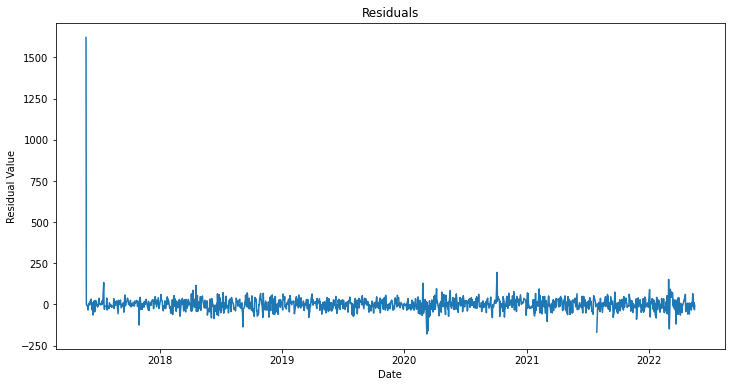

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


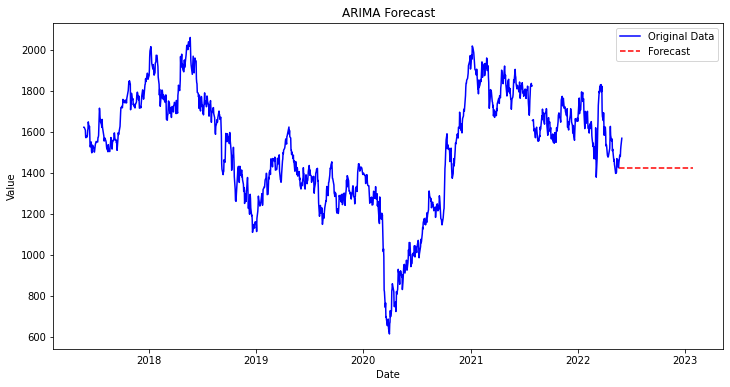

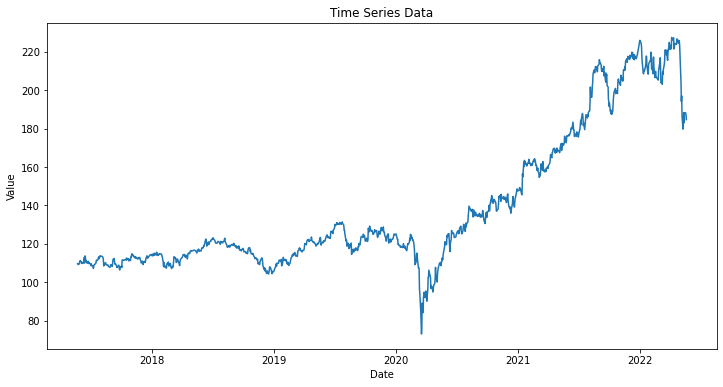

ADF Statistic: -0.7279145771051387
p-value: 0.8393859453841682
Critical Values:
1%: -3.4356474307506084
5%: -2.8638793281844253
10%: -2.5680154897465575
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5279.134, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5275.931, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5276.320, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5278.294, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5276.110, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5276.748, Time=0.49 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5277.907, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5274.945, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5275.045, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5275.689, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5275.352, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5276.86

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


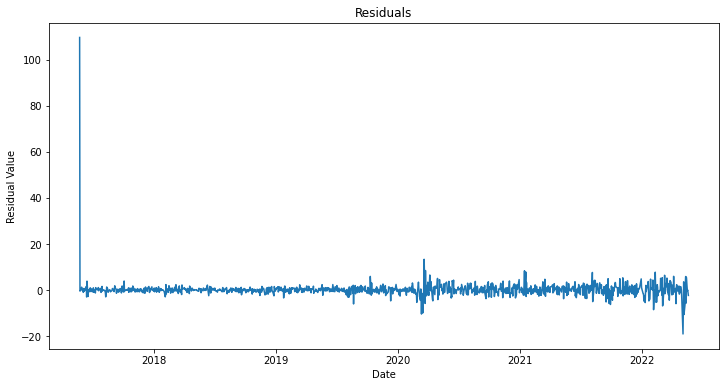

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


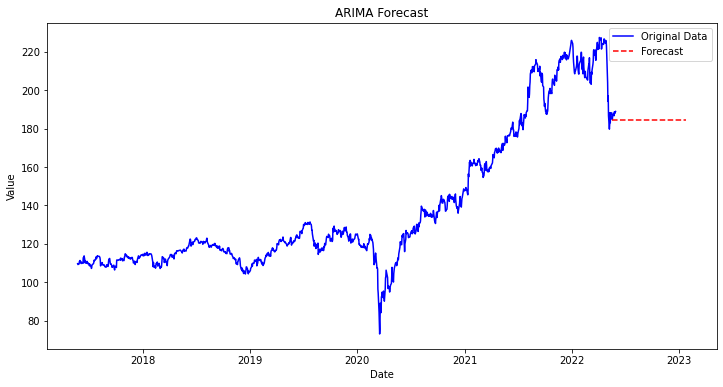

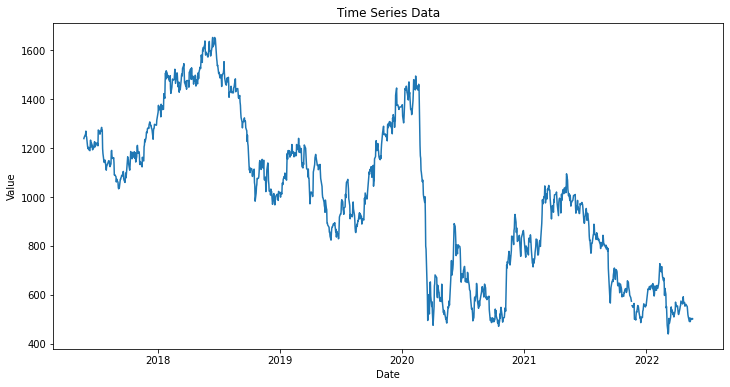

ADF Statistic: -1.4680774726835948
p-value: 0.5492397373587183
Critical Values:
1%: -3.4355629707955395
5%: -2.863842063387667
10%: -2.567995644141416
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11954.882, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11953.839, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11954.127, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11953.439, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11954.087, Time=0.42 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.900 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1260
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5975.719
Date:                Thu, 12 Oct 2023   AIC                          11953.439
Time:                        13:57:13   BIC      

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


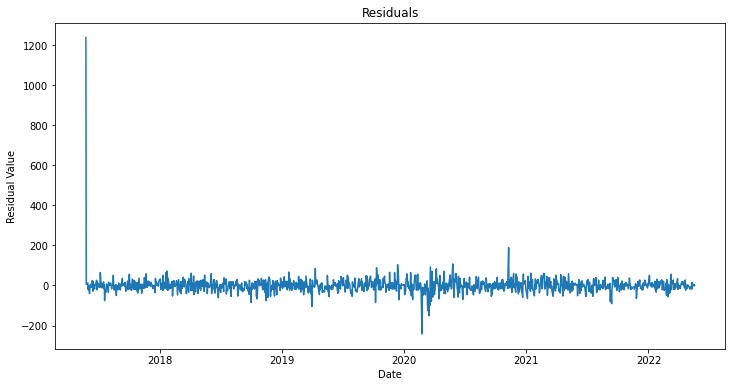

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


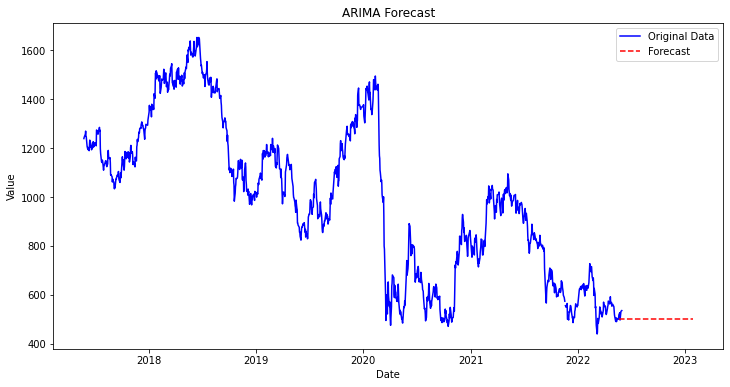

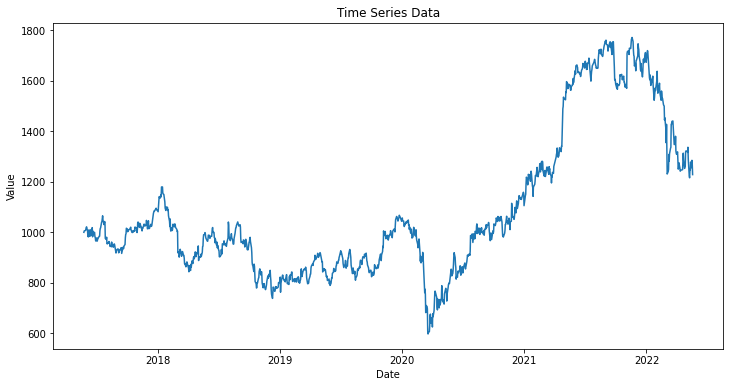

ADF Statistic: -1.2029232044817255
p-value: 0.6723369607016554
Critical Values:
1%: -3.435550533536195
5%: -2.863836575823745
10%: -2.567992721718317
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11127.987, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11129.975, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11129.975, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11126.091, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11131.953, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.648 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1261
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5562.045
Date:                Thu, 12 Oct 2023   AIC                          11126.091
Time:                        13:57:14   BIC       

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


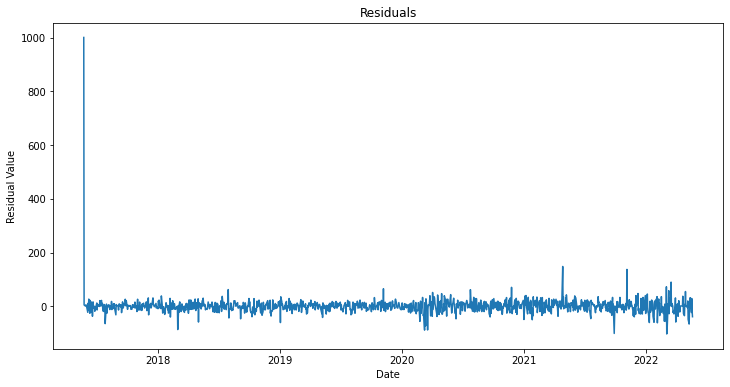

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


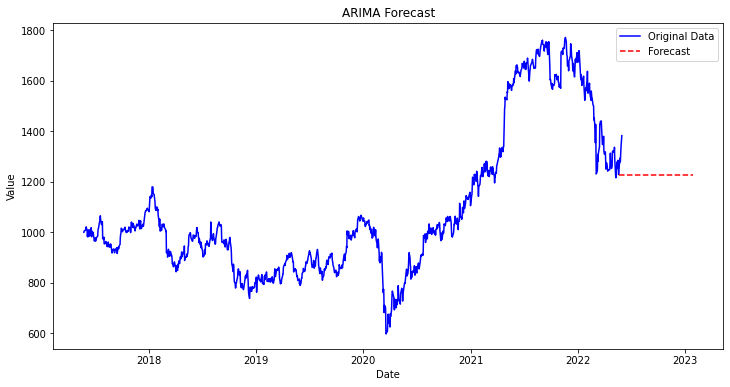

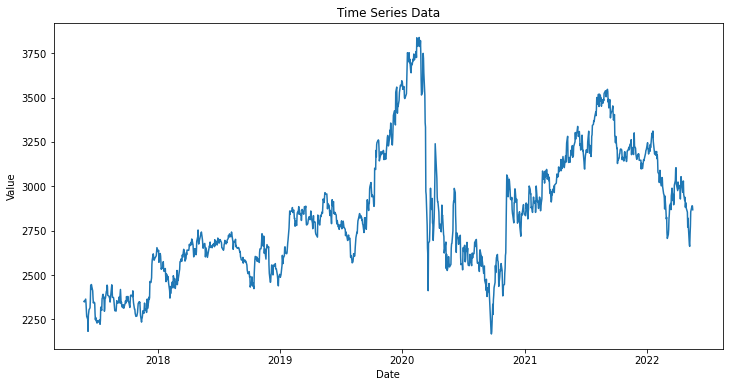

ADF Statistic: -2.2334347292512007
p-value: 0.19433508332212407
Critical Values:
1%: -3.435621806786881
5%: -2.8638680226791444
10%: -2.5680094689100477
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13214.110, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13216.110, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13216.112, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13212.211, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13217.015, Time=0.48 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.727 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1261
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6605.105
Date:                Thu, 12 Oct 2023   AIC                          13212.211
Time:                        13:57:16   BIC    

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


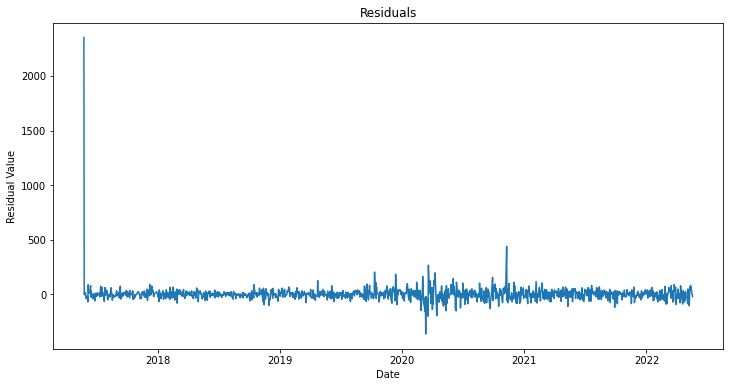

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


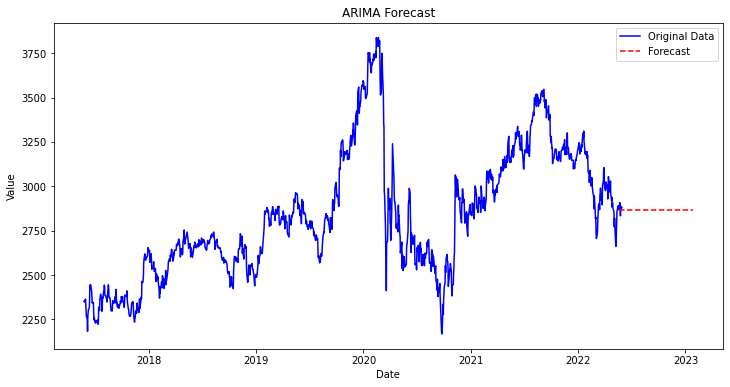

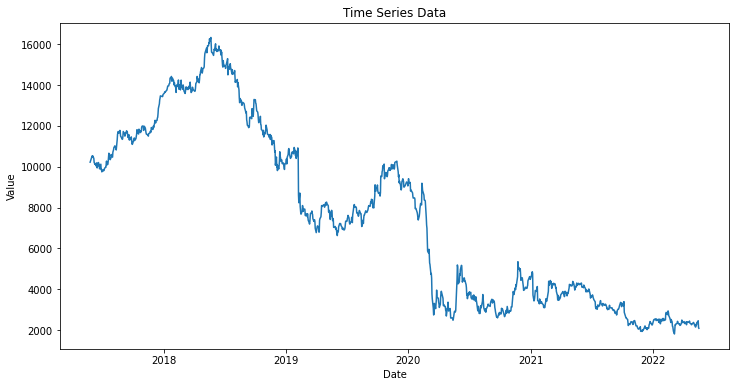

ADF Statistic: -0.49502013293176544
p-value: 0.8929846261984101
Critical Values:
1%: -3.435554672689999
5%: -2.863838402102491
10%: -2.5679936943096284
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16830.712, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16828.757, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16828.687, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16830.133, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16830.582, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16830.613, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16832.616, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=16827.968, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16829.853, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=16829.911, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=16828.032, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : A

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


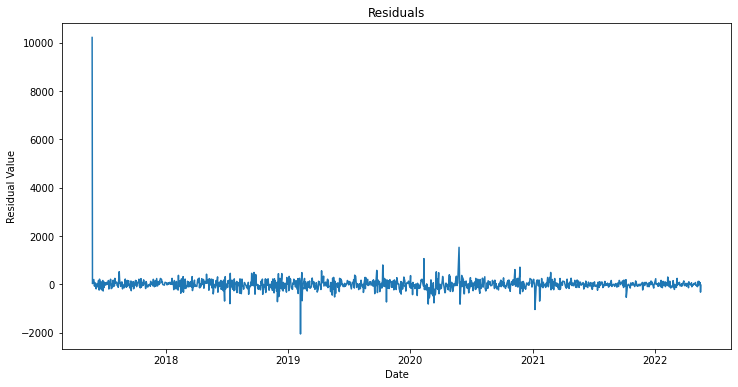

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


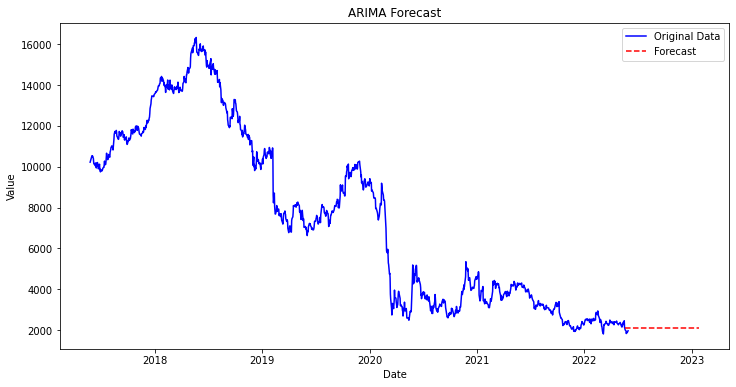

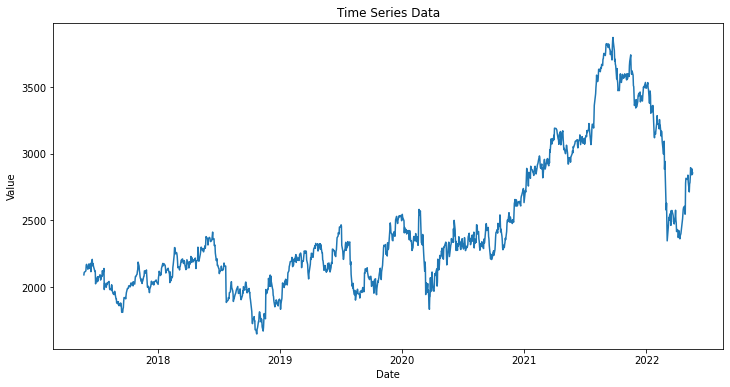

ADF Statistic: -1.3569443099034126
p-value: 0.6027347964805617
Critical Values:
1%: -3.435554672689999
5%: -2.863838402102491
10%: -2.5679936943096284
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13074.386, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13068.607, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13069.106, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13072.633, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13069.409, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13069.712, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13071.380, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=13066.895, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=13067.679, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=13067.978, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=13067.394, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AI

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


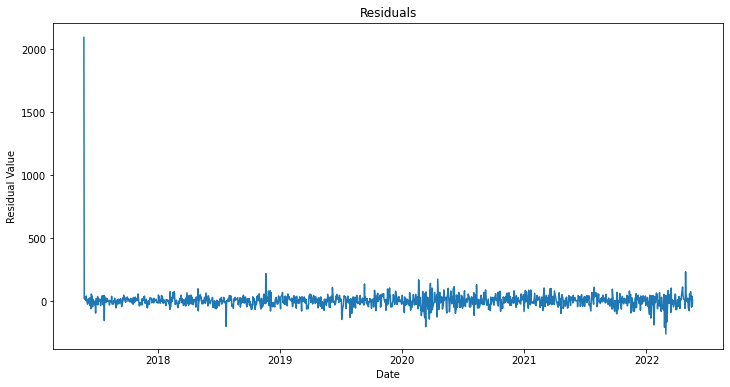

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


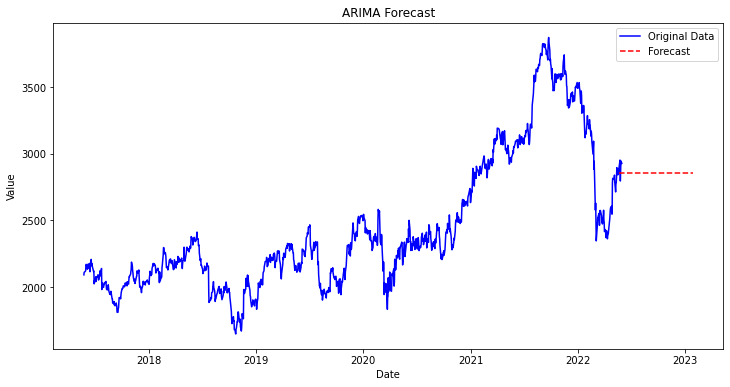

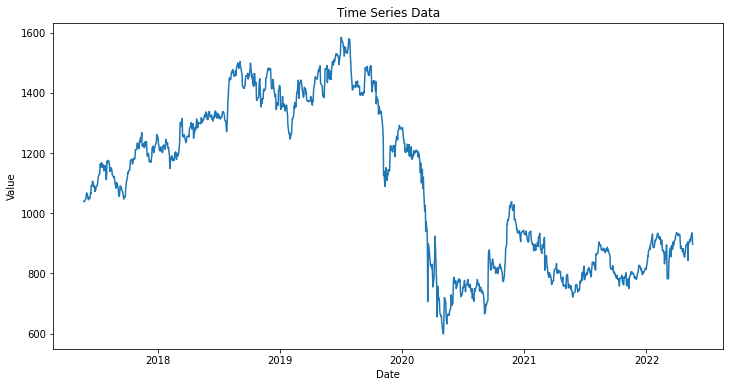

ADF Statistic: -1.3017437777876244
p-value: 0.6283741560769385
Critical Values:
1%: -3.435630320520318
5%: -2.863871779019612
10%: -2.56801146937726
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11173.403, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11174.178, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11174.015, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11171.442, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11173.490, Time=0.41 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.766 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1261
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5584.721
Date:                Thu, 12 Oct 2023   AIC                          11171.442
Time:                        13:57:22   BIC        

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


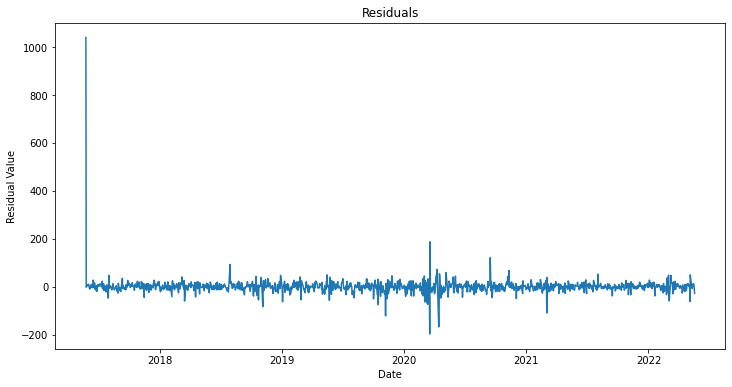

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


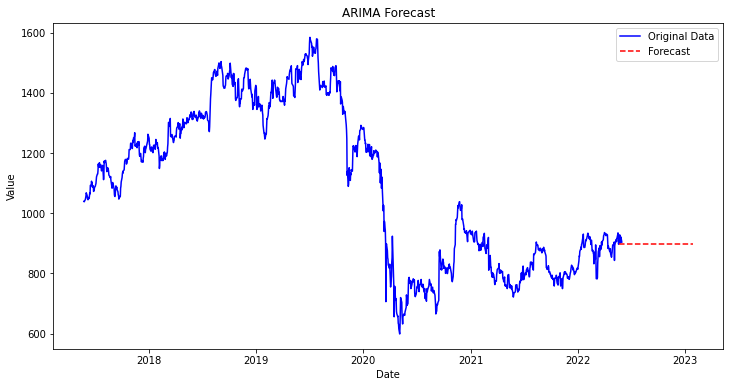

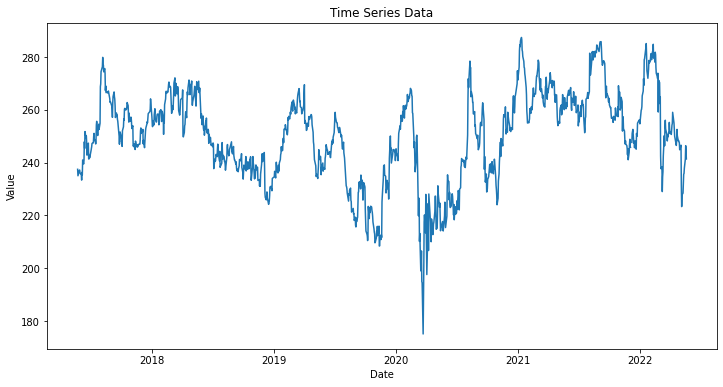

ADF Statistic: -3.6910694003387
p-value: 0.004240539089160389
Critical Values:
1%: -3.4355880246374304
5%: -2.8638531175675896
10%: -2.568001531098063
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6935.202, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6930.987, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6931.367, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6933.203, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6931.893, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6932.425, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6933.831, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6928.989, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=6929.894, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6930.426, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6929.368, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6931.832,

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


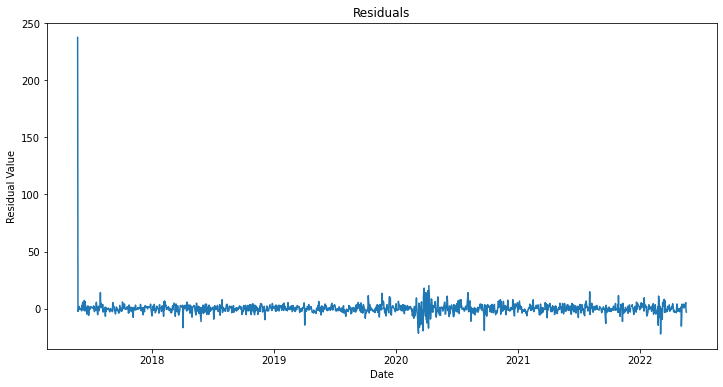

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


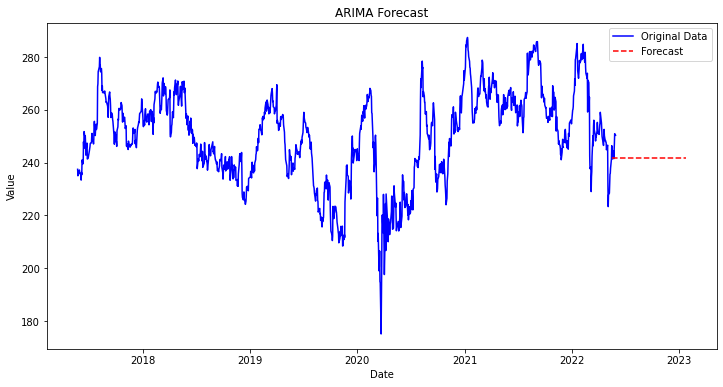

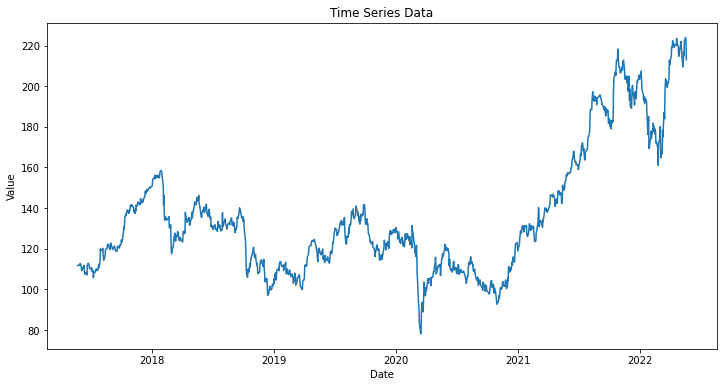

ADF Statistic: -0.7598057661555705
p-value: 0.8306447271478545
Critical Values:
1%: -3.4355796466416777
5%: -2.863849421064024
10%: -2.5679995625056926
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5924.759, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5924.042, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5924.331, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5924.027, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5925.004, Time=0.32 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.657 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1261
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2961.014
Date:                Thu, 12 Oct 2023   AIC                           5924.027
Time:                        13:57:26   BIC          

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


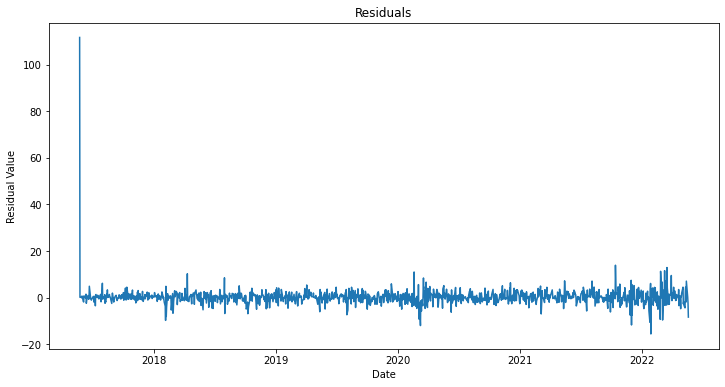

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


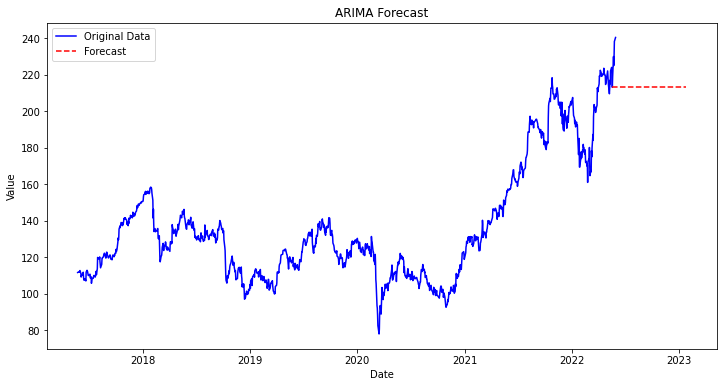

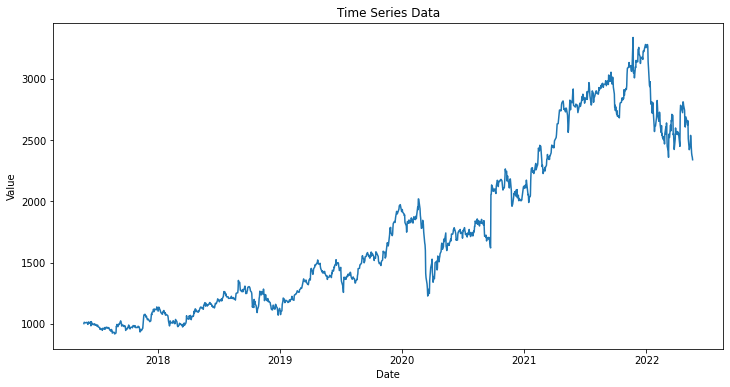

ADF Statistic: -1.1136109945201658
p-value: 0.7096135883365229
Critical Values:
1%: -3.435550533536195
5%: -2.863836575823745
10%: -2.567992721718317
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12723.889, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12725.880, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12725.879, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12722.890, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12727.883, Time=0.30 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.630 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1261
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6360.445
Date:                Thu, 12 Oct 2023   AIC                          12722.890
Time:                        13:57:28   BIC       

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


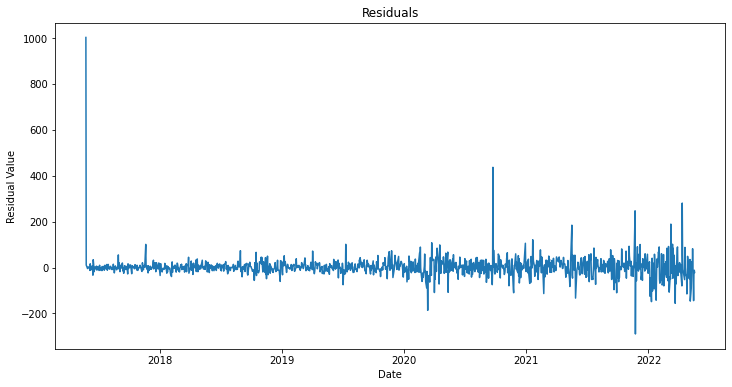

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


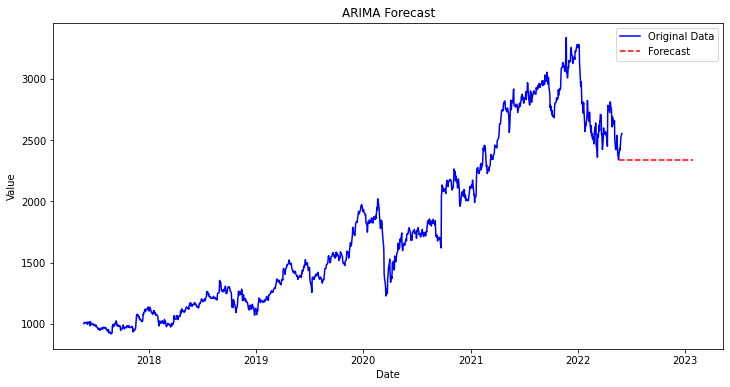

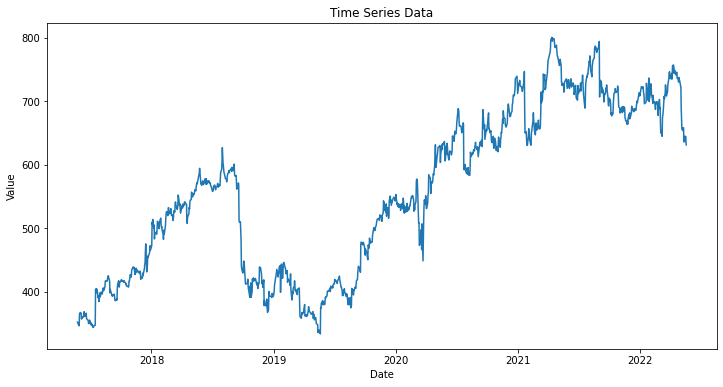

ADF Statistic: -1.765042801731125
p-value: 0.39794981165376503
Critical Values:
1%: -3.435554672689999
5%: -2.863838402102491
10%: -2.5679936943096284
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9484.804, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9481.876, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9481.622, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9483.373, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9482.267, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9482.857, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9484.265, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=9480.279, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=9481.002, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=9481.553, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=9480.523, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=9483.001,

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


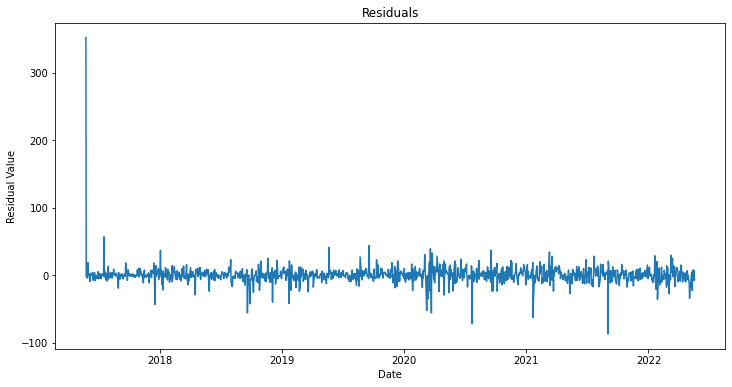

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


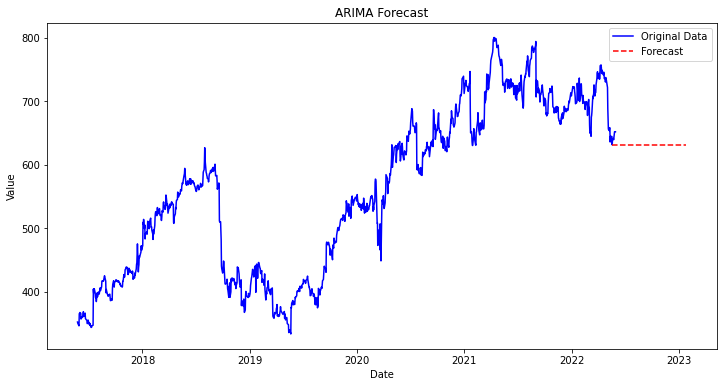

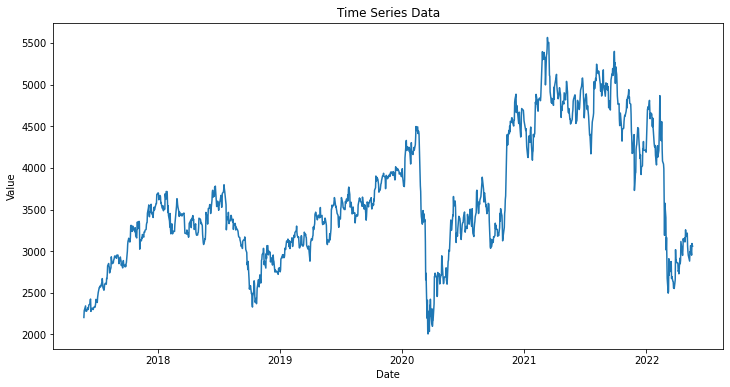

ADF Statistic: -2.6824430420057066
p-value: 0.07712597535874971
Critical Values:
1%: -3.4355796466416777
5%: -2.863849421064024
10%: -2.5679995625056926
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15214.769, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15216.243, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15216.275, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15212.826, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15217.907, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.510 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1261
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -7605.413
Date:                Thu, 12 Oct 2023   AIC                          15212.826
Time:                        13:57:32   BIC    

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


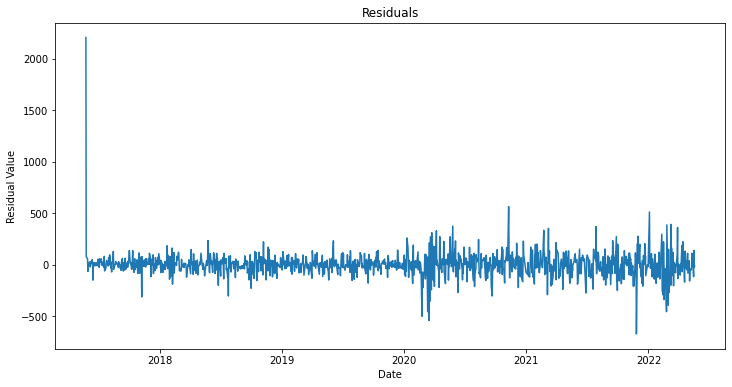

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


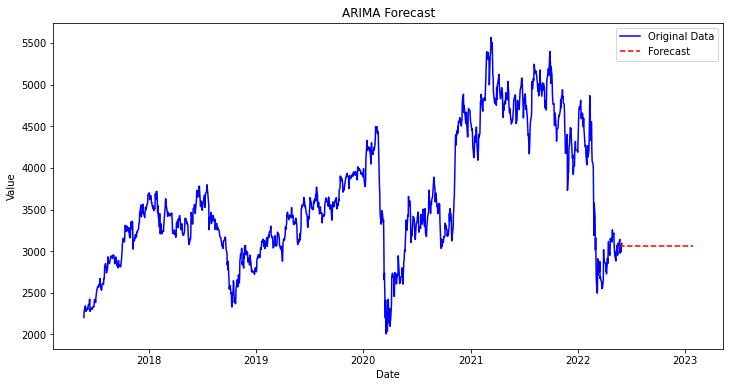

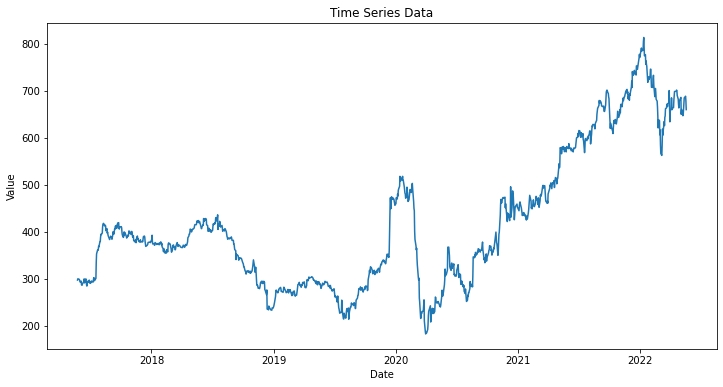

ADF Statistic: -0.7887785002331447
p-value: 0.8223960955459206
Critical Values:
1%: -3.435550533536195
5%: -2.863836575823745
10%: -2.567992721718317
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9387.622, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9389.304, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9389.307, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9386.661, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9388.111, Time=0.66 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.962 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1261
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4692.331
Date:                Thu, 12 Oct 2023   AIC                           9386.661
Time:                        13:57:34   BIC            

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


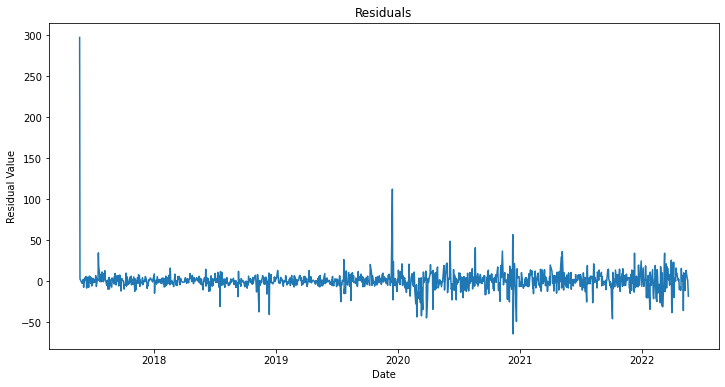

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


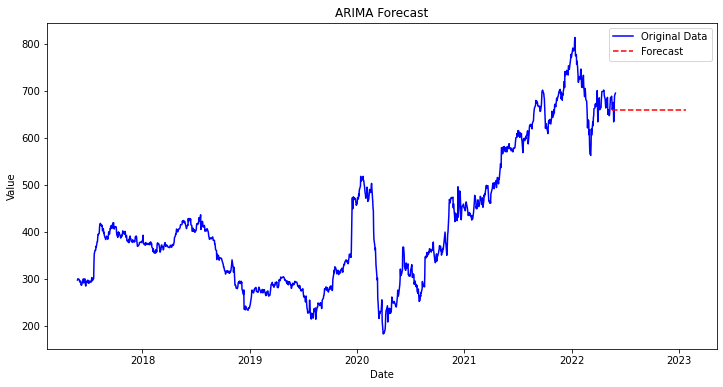

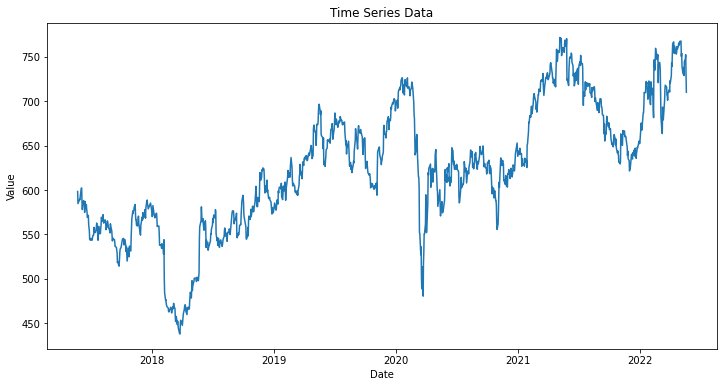

ADF Statistic: -1.9568296653804438
p-value: 0.30581646636316984
Critical Values:
1%: -3.4355880246374304
5%: -2.8638531175675896
10%: -2.568001531098063
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9096.678, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9098.666, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9098.667, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9094.802, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9100.663, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.632 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1261
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4546.401
Date:                Thu, 12 Oct 2023   AIC                           9094.802
Time:                        13:57:36   BIC         

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


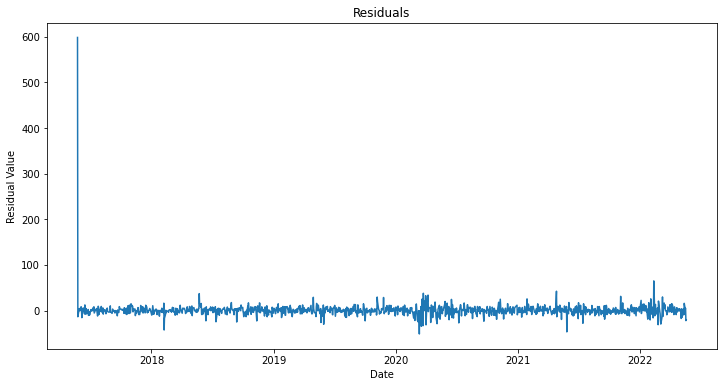

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


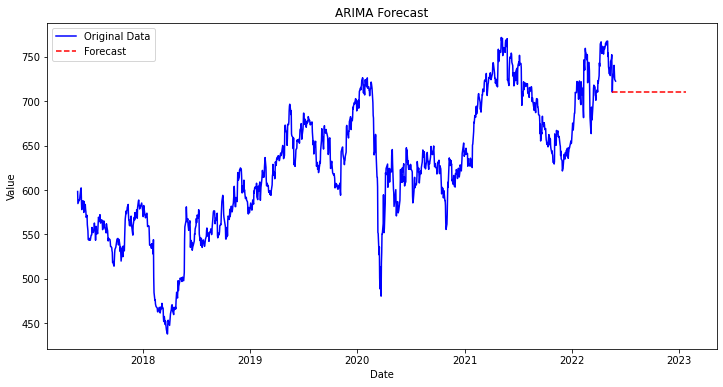

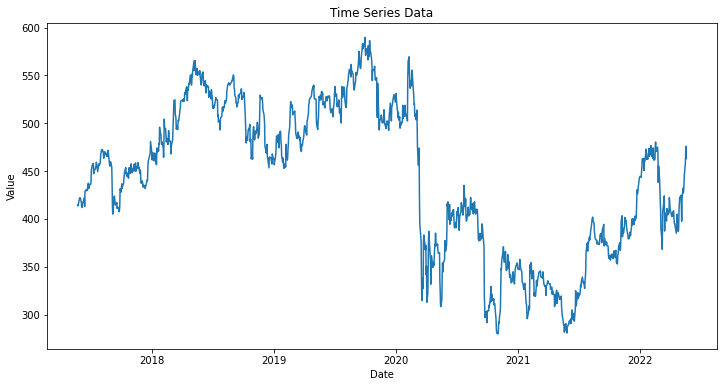

ADF Statistic: -2.037206460921732
p-value: 0.2705013034534181
Critical Values:
1%: -3.435554672689999
5%: -2.863838402102491
10%: -2.5679936943096284
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8992.992, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8993.182, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8993.167, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8991.018, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8995.166, Time=0.54 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.873 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1261
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4494.509
Date:                Thu, 12 Oct 2023   AIC                           8991.018
Time:                        13:57:38   BIC            

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


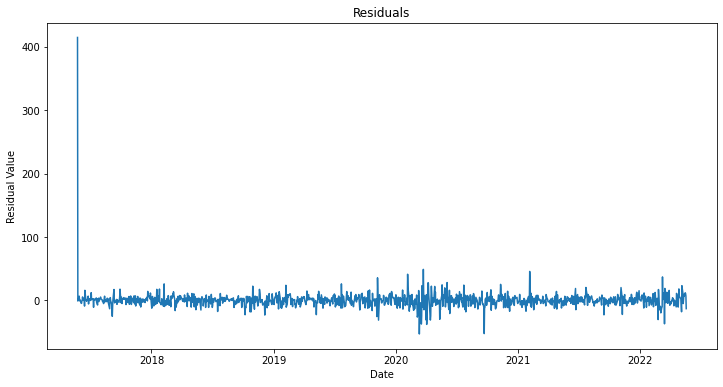

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


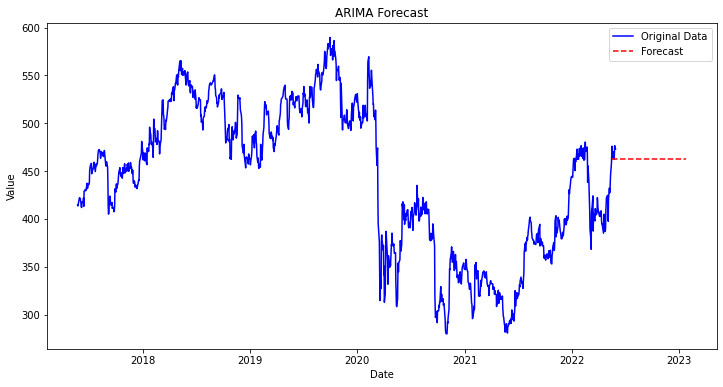

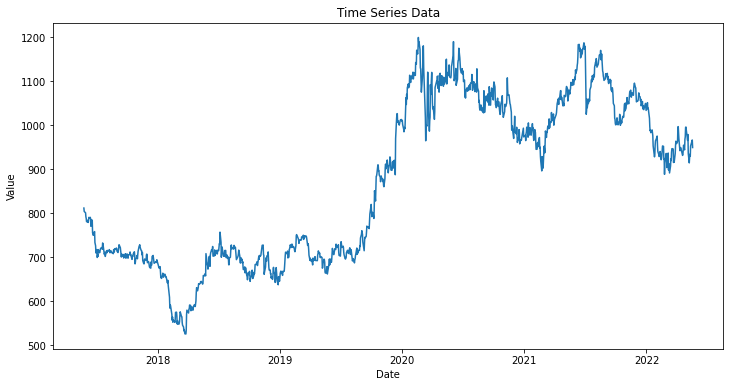

ADF Statistic: -1.2146472436414286
p-value: 0.6672633136702746
Critical Values:
1%: -3.4356260602190356
5%: -2.863869899335344
10%: -2.5680104683371323
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10371.635, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10372.751, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10372.655, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10369.703, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10360.199, Time=0.56 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10358.353, Time=0.59 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10371.859, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10357.192, Time=0.70 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=10370.043, Time=0.33 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=10354.249, Time=0.88 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=10361.209, Time=0.46 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : A

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


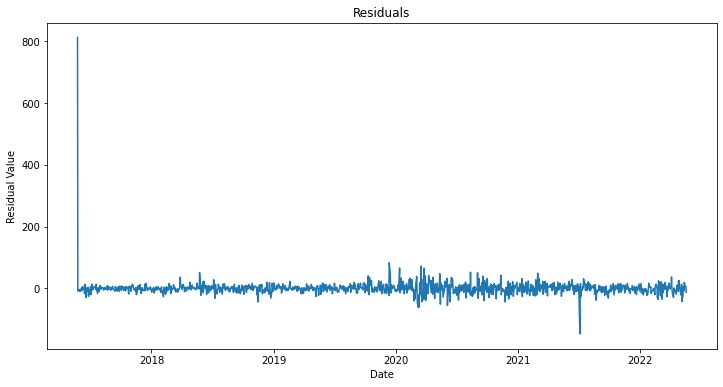

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


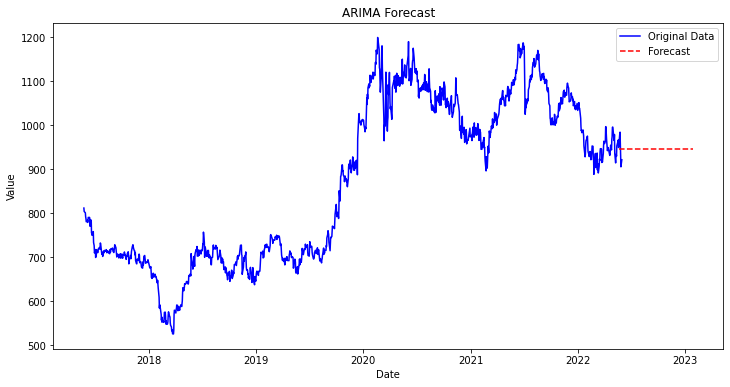

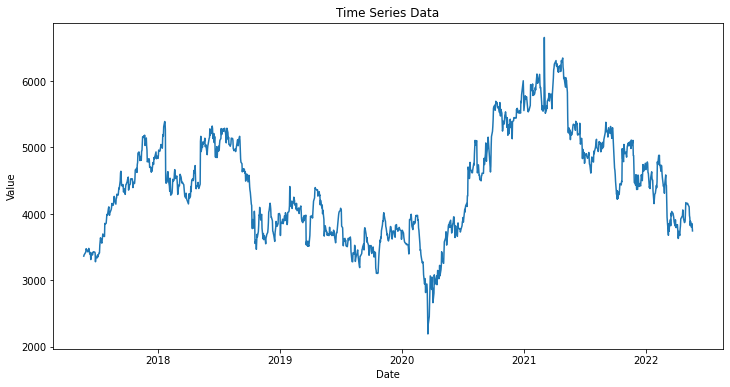

ADF Statistic: -2.534087594390405
p-value: 0.1073991692739889
Critical Values:
1%: -3.435550533536195
5%: -2.863836575823745
10%: -2.567992721718317
number of differencing was 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15307.430, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15309.349, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15309.348, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15305.441, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15307.836, Time=0.53 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.766 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1261
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -7651.721
Date:                Thu, 12 Oct 2023   AIC                          15305.441
Time:                        13:58:04   BIC        

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


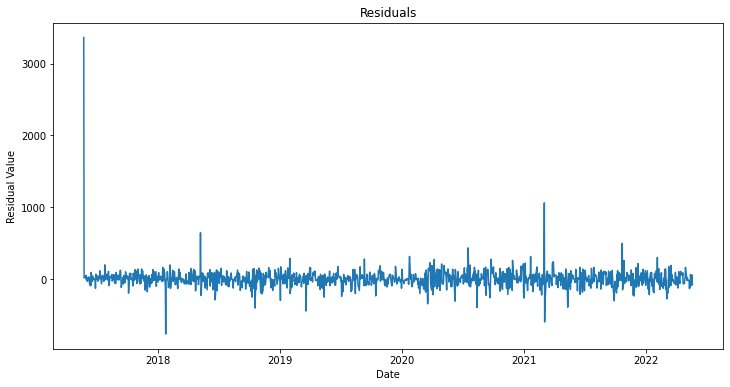

/Users/kennong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


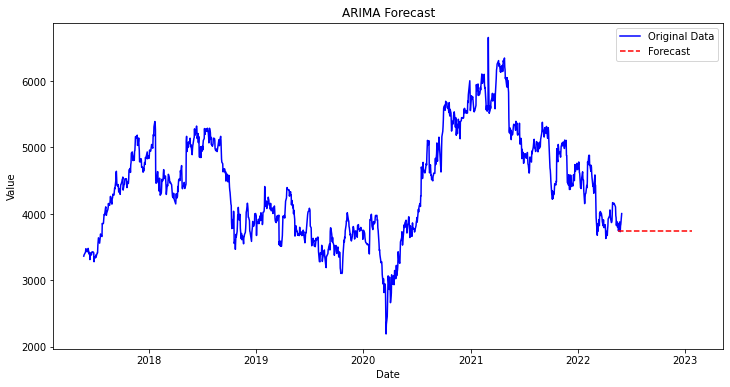

optimal_p  optimal_q  optimal_d  prediction_price
ICP.L         0.0        0.0        1.0       1235.345947
ABDN.L        0.0        0.0        1.0        158.123749
SMDS.L        0.0        0.0        1.0        265.466949
HL.L          0.0        0.0        1.0        806.749329
DPH.L         0.0        0.0        1.0       3343.406250
HIK.L         0.0        0.0        1.0       1637.264282
HWDN.L        0.0        0.0        1.0        625.703003
IDS.L         1.0        1.0        1.0        285.343318
ITV.L         0.0        0.0        1.0         64.932495
CCL.L         1.0        1.0        1.0       1002.849434
INVP.L        2.0        1.0        1.0        415.657654
CNA.L         0.0        0.0        1.0         83.221420
CTEC.L        0.0        0.0        1.0        210.840530
UTG.L         1.0        0.0        1.0        990.637068
JMAT.L        0.0        0.0        1.0       2173.121338
WEIR.L        0.0        0.0        1.0       1424.101196
BBOX.L        1.0        0.0        1.0        184.528078
EZJ.L         0.0        0.0        1.0        501.600006
IMI.L         0.0        0.0        1.0       1228.911133
DLN.L         0.0        0.0        1.0       2867.641113
TUI.L         0.0        1.0        1.0       2090.185418
SXS.L         1.0        0.0        1.0       2855.227918
HSX.L         0.0        0.0        1.0        897.089661
DLG.L         1.0        0.0        1.0        241.593584
EMG.L         0.0        0.0        1.0        213.079697
DPLM.L        0.0        0.0        1.0       2339.821045
IGG.L         0.0        1.0        1.0        631.892486
WIZZ.L        0.0        0.0        1.0       3061.000000
FRAS.L        0.0        0.0        1.0        660.000000
TATE.L        0.0        0.0        1.0        710.041382
BEZ.L         0.0        0.0        1.0        463.116974
PNN.L         2.0        4.0        1.0        946.781642
RSW.L         0.0        0.0        1.0       3744.684082

In [8]:
"""
ARIMA


#inputs = df, dataframe of close prices.
#outputs = dataframe of (params_dict). contains the optimized params (p, d, q) using auto-arima
        # = plots of original time series
        # = plots of results.summary() of fitting optimized params into ARIMA(p,d,q)
        # = plots of residuals
        # = plots of forecast (3 days look-ahead) 
"""


params_dict = {}


for column in df.columns:

    # Visualize your time series data
    plt.figure(figsize=(12, 6))
    plt.plot(df[column].iloc[:-7])
    plt.title('Time Series Data')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.show()

    # Check for stationarity using Augmented Dickey-Fuller test
    from statsmodels.tsa.stattools import adfuller

    result = adfuller(df[column].iloc[:-7].dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'{key}: {value}')
    
    
    
    # If the data is not stationary, apply differencing to make it stationary
    #while result[1] > 0.05:  # Adjust the significance level as needed
    
    data_diff = df[column].iloc[:-7].diff().dropna() #first differencing
    d = 1
    print("number of differencing was {}".format(d))
    
    while adfuller(data_diff)[1] > 0.05:
        data_diff = data_diff.diff().dropna()
        d += 1
        print("number of differencing was {}".format(d))

    else:
        #data_diff = data
        data_diff = df[column].iloc[:-7].dropna()
#         plt.figure(figsize=(12, 6))
#         plt.plot(data_diff)
#         plt.title('Differenced Time Series Data')
#         plt.xlabel('Date')
#         plt.ylabel('Value')
#         plt.show()

    # Fit an ARIMA model

    p_range = range(0, 5)
    q_range = range(0, 5)

    
    # Find the best ARIMA model using auto_arima
    best_model = auto_arima(df[column].iloc[:-7].dropna(), start_p=0, d=1, start_q=0,
                            max_p=4, max_d=4, max_q=4,
                            seasonal=True, trace=True,
                            stepwise=True, error_action='ignore', suppress_warnings=True)

    print(best_model.summary())
    
    p_optimal = best_model.get_params()['order'][0]
    d_optimal = best_model.get_params()['order'][1]
    q_optimal = best_model.get_params()['order'][2]
                                                 
    
    for differencing_count in range(d_optimal):
        data_diff = data_diff.iloc[:-7].diff().dropna()
    
    
    """to edit"""
    #model = sm.tsa.ARIMA(data_diff, order=(p_optimal, d_optimal, q_optimal))
    model = sm.tsa.ARIMA(df[column].iloc[:-7], order=(p_optimal, d_optimal, q_optimal))
    results = model.fit()

    # Print model summary
    #print(results.summary())

    # Plot the residuals to check for randomness
    # residuals should show no predictability in variance and have mean of 0
    residuals = results.resid
    plt.figure(figsize=(12, 6))
    plt.plot(residuals)
    plt.title('Residuals')
    plt.xlabel('Date')
    plt.ylabel('Residual Value')
    plt.show()

    # Forecast future values
    forecast_steps = 3  # Number of time steps to forecast ahead
    forecast, stderr, conf_int = results.forecast(steps=forecast_steps)
    
    #create dictionary to store params
    """to edit"""
    params_dict[column] = {"optimal_p": p_optimal,
                           "optimal_q": q_optimal, 
                           "optimal_d": d_optimal,
                          #"deviations from last known price" : forecast,
                          #"prediction_price" : forecast+df[column].iloc[-1]
                          "prediction_price" : forecast}

    
    last_date = df[column].iloc[:-7].index[-1]
    additional_x = 250
    forecast_index = pd.date_range(start=last_date, periods=forecast_steps+additional_x, freq='D')
    
    
    """to edit"""
    # Create a DataFrame for the forecasted values
    #forecast_df = pd.DataFrame({'Forecast': df[column].iloc[-1]+forecast}, index=forecast_index)
    forecast_df = pd.DataFrame({'Forecast': forecast}, index=forecast_index)
    
    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the original data
    ax.plot(df[column], label='Original Data', color='blue')

    # Plot the forecasted values
    ax.plot(forecast_df, label='Forecast', linestyle='--', color='red')

    ax.set_title('ARIMA Forecast')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()

    # Show the plot
    plt.show() 
    
params_df = pd.DataFrame(params_dict).T
    
display(params_df)
    


In [9]:
file = pd.read_csv("prediction_result_3days_200622.csv")
file

Unnamed: 0  Actual Price Predicted Price       MSE       MAE  R2  \
0       CCL.L   1011.500000     [1102.1017]  0.004354  0.065982   1   
1       PNN.L    921.890503      [978.6994]  0.094318  0.307112   1   
2       IGG.L    652.198731      [628.6662]  0.035130  0.187431   1   
3       ITV.L     65.962585     [66.964294]  0.002242  0.047346   1   
4      INVP.L    433.472778      [401.9024]  0.167294  0.409016   1   
5       EMG.L    240.397629      [223.5084]  0.285668  0.534479   1   
6      TATE.L    722.515076      [747.0776]  0.113386  0.336728   1   
7       RSW.L   4005.439697     [3899.5273]  0.019304  0.138940   1   
8       IDS.L    313.700653     [276.65097]  0.108747  0.329769   1   
9       SXS.L   2927.939453     [2899.7961]  0.003010  0.054867   1   
10      HSX.L    904.025879     [924.79584]  0.005985  0.077362   1   
11     FRAS.L    695.000000      [648.7346]  0.101715  0.318928   1   
12      BEZ.L    473.095398      [459.9702]  0.027568  0.166035   1   
13     WIZZ.L   3094.000000     [3054.6003]  0.002874  0.053610   1   
14      DLN.L   2879.104248     [2870.5718]  0.000610  0.024702   1   
15      DLG.L    250.364975      [232.5869]  1.044022  1.021774   1   
16     ABDN.L    175.403336      [163.5097]  0.077741  0.278821   1   
17     DPLM.L   2553.907471     [2410.2227]  0.045431  0.213145   1   
18     BBOX.L    188.927795     [208.25749]  0.279559  0.528733   1   
19      IMI.L   1383.135132       [1250.15]  0.208410  0.456519   1   
20     HWDN.L    660.338989     [637.03265]  0.022085  0.148612   1   
21      HIK.L   1640.628174      [1627.581]  0.000760  0.027571   1   
22     JMAT.L   1990.937866     [1888.5277]  0.064393  0.253758   1   
23     SMDS.L    282.856812     [267.72086]  0.095043  0.308290   1   
24       HL.L    824.121399      [752.5042]  0.084401  0.290519   1   
25      EZJ.L    535.200012     [526.18634]  0.000791  0.028124   1   
26      DPH.L   3567.611328     [3383.6902]  0.043994  0.209748   1   
27     WEIR.L   1567.920288     [1492.0137]  0.072201  0.268702   1   
28      CNA.L     74.384422     [85.310745]  0.139973  0.374130   1   
29      ICP.L   1464.248291     [1264.2468]  0.236230  0.486035   1   
30     CTEC.L    212.978073     [172.95068]  1.607907  1.268033   1   
31      UTG.L   1094.273804      [984.9353]  0.442204  0.664984   1   
32      TUI.L   1970.500000      [1956.457]  0.000011  0.003248   1   

    Market Share      final_marketcap   
0      146260000   147,941,990,000.00   
1      261327008   240914886834.23047   
2      395398016    257878084065.0625   
3     4034409984   266120113306.78125   
4      645161984   279,660,157,671.13   
5     1199859968    288443491180.2617   
6      401665984   290209728829.28516   
7       72788496   291549931382.66016   
8      956193024    299958376095.6797   
9      102758000   300869202324.21875   
10     347103008    313790101878.2031   
11     454926016   316,173,581,120.00   
12     672462976   318139139236.83594   
13     103335000   319,718,490,000.00   
14     112291000   323297495117.43164   
15    1311399936   328,328,612,159.63   
16    1899229952    333131268597.6992   
17     134034000   342310433928.22266   
18    1903740032    359669407279.8203   
19     260858000   360,801,864,220.46   
20     548673024    362310190101.1875   
21     221079008   362708449166.77344   
22     183452992    365243508442.4922   
23    1377449984   389,621,110,507.25   
24     474319008    390896444410.0488   
25     758000000    405681609252.9297   
26     113888000   406,308,118,937.50   
27     259612000    407050921830.5664   
28    5493660160   408642737326.46484   
29     290612992    425529576882.9375   
30    2049789952    436560314277.9375   
31     435726016    476803564904.1328   
32     507431008   999,892,801,264.00

In [10]:
params_df["Actual Price"] =\
(
        file["Actual Price"].values
)

In [11]:
params_df["deviation from actual price"]=\
(
    params_df["Actual Price"] - params_df["prediction_price"].values

)

In [12]:
params_df["log_forecast/actual"] =\
(
    np.log(params_df["prediction_price"].values / file["Actual Price"].values)
)
params_df

optimal_p  optimal_q  optimal_d  prediction_price  Actual Price  \
ICP.L         0.0        0.0        1.0       1235.345947   1011.500000   
ABDN.L        0.0        0.0        1.0        158.123749    921.890503   
SMDS.L        0.0        0.0        1.0        265.466949    652.198731   
HL.L          0.0        0.0        1.0        806.749329     65.962585   
DPH.L         0.0        0.0        1.0       3343.406250    433.472778   
HIK.L         0.0        0.0        1.0       1637.264282    240.397629   
HWDN.L        0.0        0.0        1.0        625.703003    722.515076   
IDS.L         1.0        1.0        1.0        285.343318   4005.439697   
ITV.L         0.0        0.0        1.0         64.932495    313.700653   
CCL.L         1.0        1.0        1.0       1002.849434   2927.939453   
INVP.L        2.0        1.0        1.0        415.657654    904.025879   
CNA.L         0.0        0.0        1.0         83.221420    695.000000   
CTEC.L        0.0        0.0        1.0        210.840530    473.095398   
UTG.L         1.0        0.0        1.0        990.637068   3094.000000   
JMAT.L        0.0        0.0        1.0       2173.121338   2879.104248   
WEIR.L        0.0        0.0        1.0       1424.101196    250.364975   
BBOX.L        1.0        0.0        1.0        184.528078    175.403336   
EZJ.L         0.0        0.0        1.0        501.600006   2553.907471   
IMI.L         0.0        0.0        1.0       1228.911133    188.927795   
DLN.L         0.0        0.0        1.0       2867.641113   1383.135132   
TUI.L         0.0        1.0        1.0       2090.185418    660.338989   
SXS.L         1.0        0.0        1.0       2855.227918   1640.628174   
HSX.L         0.0        0.0        1.0        897.089661   1990.937866   
DLG.L         1.0        0.0        1.0        241.593584    282.856812   
EMG.L         0.0        0.0        1.0        213.079697    824.121399   
DPLM.L        0.0        0.0        1.0       2339.821045    535.200012   
IGG.L         0.0        1.0        1.0        631.892486   3567.611328   
WIZZ.L        0.0        0.0        1.0       3061.000000   1567.920288   
FRAS.L        0.0        0.0        1.0        660.000000     74.384422   
TATE.L        0.0        0.0        1.0        710.041382   1464.248291   
BEZ.L         0.0        0.0        1.0        463.116974    212.978073   
PNN.L         2.0        4.0        1.0        946.781642   1094.273804   
RSW.L         0.0        0.0        1.0       3744.684082   1970.500000   

        deviation from actual price  log_forecast/actual  
ICP.L                   -223.845947             0.199917  
ABDN.L                   763.766754            -1.763049  
SMDS.L                   386.731781            -0.898859  
HL.L                    -740.786743             2.503925  
DPH.L                  -2909.933472             2.042916  
HIK.L                  -1396.866653             1.918488  
HWDN.L                    96.812073            -0.143862  
IDS.L                   3720.096379            -2.641716  
ITV.L                    248.768158            -1.575091  
CCL.L                   1925.090019            -1.071454  
INVP.L                   488.368225            -0.776996  
CNA.L                    611.778580            -2.122407  
CTEC.L                   262.254868            -0.808195  
UTG.L                   2103.362932            -1.138872  
JMAT.L                   705.982910            -0.281315  
WEIR.L                 -1173.736221             1.738376  
BBOX.L                    -9.124742             0.050714  
EZJ.L                   2052.307465            -1.627577  
IMI.L                  -1039.983337             1.872519  
DLN.L                  -1484.505981             0.729137  
TUI.L                  -1429.846429             1.152255  
SXS.L                  -1214.599744             0.554072  
HSX.L                   1093.848206            -0.797205  
DLG.L                     41.263227      

<Axes: >

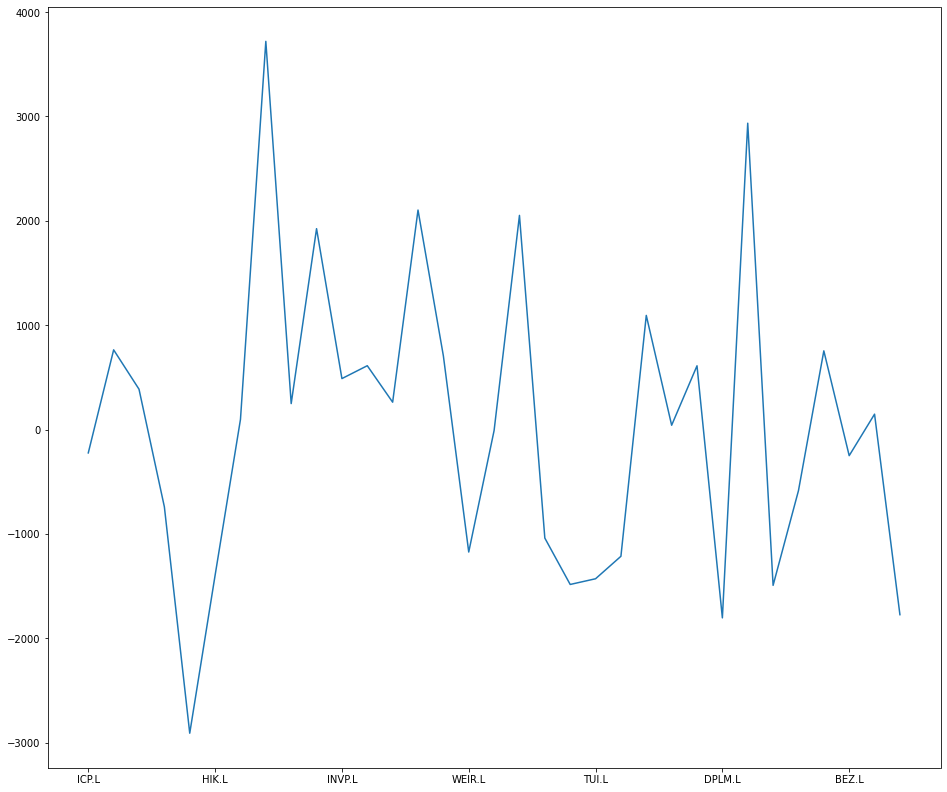

In [14]:
#however, this is not good analysis because the analysis should be factor in the stock price as a reference.
params_df["deviation from actual price"].plot(figsize=[16,14])

<Axes: >

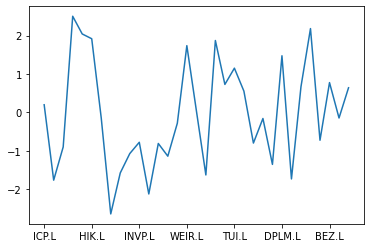

In [15]:
params_df["log_forecast/actual"].plot()

In [16]:
#can we use this mean as a measure of comparison between ARIMA and LSTM?
#larger mean away from 0 implies lower accuracy

abs(params_df["log_forecast/actual"]).mean()

1.1595378720086804

In [17]:
#descaling from the effects of log

abs(params_df["log_forecast/actual"]).apply(np.exp).mean()

4.15551701066417

In [18]:
params_df.to_excel("params_df_with_iloc[-7].xlsx")